# PSTN-056

Plots to support PSTN-056, the Phase 3 recommendations of the SCOC.

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp
import sqlite3
import colorcet
import cycler

from rubin_scheduler.scheduler.utils import get_current_footprint
import rubin_sim.maf as maf

outdir = "pstn-056-figs"
!mkdir $outdir
try_read_default = True

mkdir: pstn-056-figs: File exists


In [2]:
metrics = maf.get_metric_subsets('metric_subsets.json')
msets = list(metrics.groupby('metric subset').first().index)
msets

['AGN N QSO',
 'AGN SF',
 'AGN SF DDF',
 'AGN TimeLag 100 days DDF',
 'AGN TimeLag 5 days DDF',
 'AGN short',
 'AGN timelag',
 'DDF Cadence',
 'DDF Depths',
 'DESC WFD',
 'GP filters',
 'GP footprint',
 'GP season',
 'GP visit',
 'Local Volume',
 'N Visits',
 'SCOC',
 'SL IQ',
 'SL TDC',
 'SNIa DDF',
 'SNSL DDF',
 'SRD',
 'SSO N Objs',
 'SSO discovery',
 'SSO discovery options',
 'SSO fraction 3 bands',
 'SSO fraction 4 bands',
 'SSO fraction 5 bands',
 'SSO fraction 6 bands',
 'SSO lightcurve inversion',
 'Stars',
 'TVS Gaps',
 'TVS KNe',
 'TVS KNe short',
 'TVS PeriodicDetect',
 'TVS Presto',
 'TVS TDE',
 'TVS XRB',
 'TVS anomalies',
 'TVS microlensing all',
 'TVS microlensing short',
 'TVS short',
 'WFD Depths',
 'cadence',
 'galaxies',
 'plot areas',
 'radar',
 'short description']

In [3]:
# Just a prep cell .. needs to move to MAF

from matplotlib.colors import LinearSegmentedColormap, ListedColormap

filter_colors = {"u": "cyan", "g": "g", "r": "orange", "i": "r", "z": "m", "y": "b"}

filter_rgb_map = {
    "u": (74 / 256, 125 / 256, 179 / 256),
    "g": (104 / 256, 173 / 256, 87 / 256),
    "r": (238 / 256, 134 / 256, 50 / 256),
    "i": (232 / 256, 135 / 256, 189 / 256),
    "z": (209 / 256, 53 / 256, 43 / 256),
    "y": (142 / 256, 82 / 256, 159 / 256),
}

filter_color_map = ListedColormap(list(filter_rgb_map.values()))

In [4]:
figformat = 'png'
ph = maf.PlotHandler(savefig=True, fig_format=figformat, thumbnail=False, dpi=270, out_dir=outdir)

## Comparison of filter loading schemes

As the camera can only hold 5 filters at a time, we need to swap between our complete set of 6. We plan to move $u$ band in and out of the camera with the lunar cycle. It makes sense to alternate with a red filter, $z$ or $y$. 

In v3.2, we had a group of simulations which explored alternatives - swapping u with z, or u with y, or u with (alternatively) z and y. 

In [5]:
# https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.2/maf/summary.h5
summaries_v32 = maf.get_metric_summaries(summary_source="fbs_3.2/summary_v3.2.h5")
print(f"This file contains information on {len(summaries_v32)} simulations")

# https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.1/maf/summary.h5
summaries_v31 = maf.get_metric_summaries(summary_source="fbs_3.1/summary_v3.1.h5")
print(f"This file contains information on {len(summaries_v31)} simulations")

This file contains information on 52 simulations
This file contains information on 46 simulations


In [6]:
# Find the filter loading schemes
filter_sims = [r for r in summaries_v32.index if "filter" in r]
#filter_sims = [r for r in summaries_v31.index if "filters" in r] + ['starter_v3.1_10yrs']
filter_sims

['filter_uy_v3.2_10yrs', 'filter_uz_v3.2_10yrs', 'filter_uzy_v3.2_10yrs']

In [7]:
wsummaries = summaries_v32
weather_runs = [r for r in wsummaries.index if "weather" in r]
dev = np.std(wsummaries.loc[weather_runs], axis=0)
hilo = np.abs(wsummaries.loc[weather_runs].max() - wsummaries.loc[weather_runs].min())

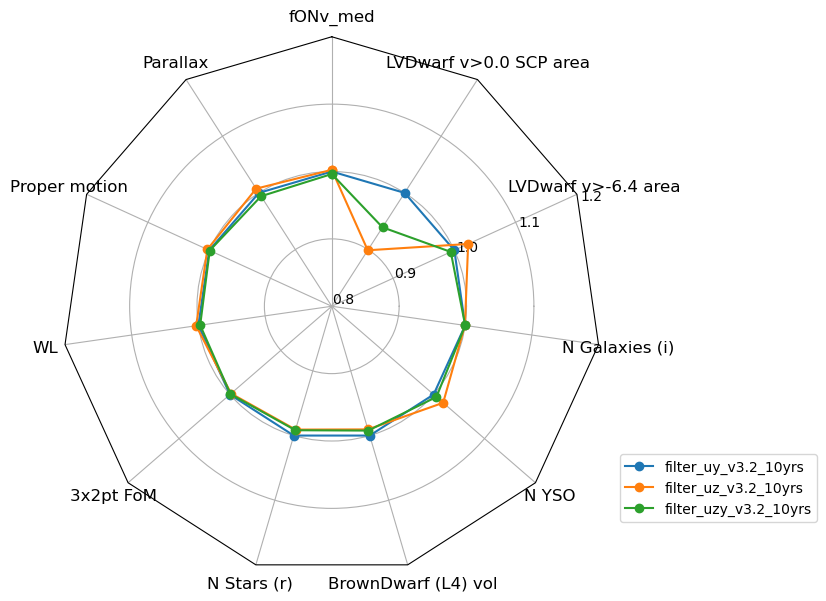

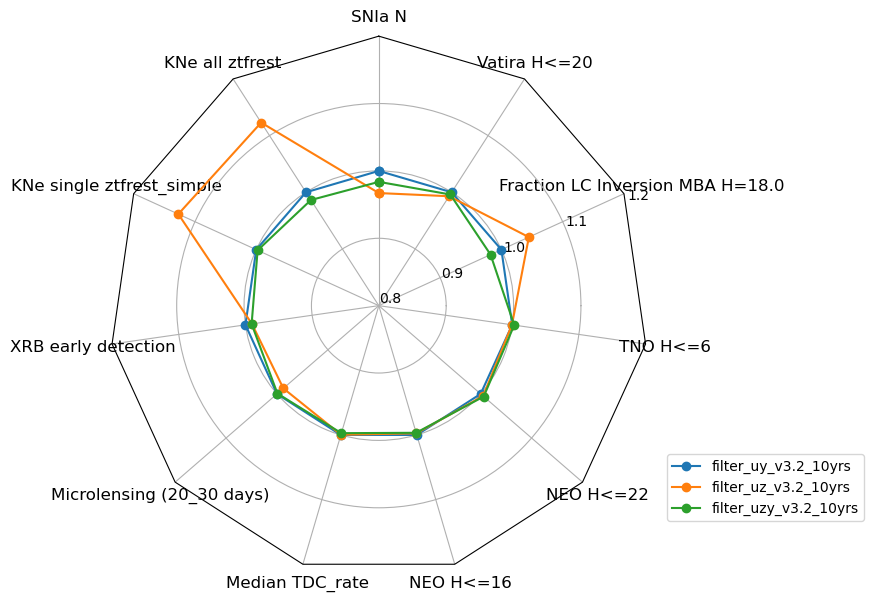

In [8]:
# Make radar plots, since there are only a few sims
# The scoc radar plot not for figure 
rr = filter_sims
baseline = 'filter_uy_v3.2_10yrs'
#baseline='filters_uy_v3.1_10yrs'
summaries = summaries_v32

msub = metrics.loc['SCOC']

statics = np.array([0, 1, 2, 3, 4, 11, 12, 13, 14, 15, 16])
variable = [i for i in np.arange(0, len(msub)) if i not in statics]

mset_stat = msub.iloc[statics]
mset_var = msub.iloc[variable]

normed = maf.normalize_metric_summaries(baseline,
                                        summaries.loc[rr, mset_stat['metric']],
                                        msub)
normed.columns = normed.columns.map(msub['short_name'])
normed

fig, ax = maf.radar(normed, rgrids=[0.80, 0.9, 1.0, 1.1, 1.2], figsize=(8, 8), bbox_to_anchor=[1.4, 0.1])
ax.tick_params(axis='x', labelsize='large')
ax.tick_params(axis='y', labelsize='medium')
fig.set_figwidth(8)
fig.set_figheight(7)
plt.savefig(os.path.join(outdir, 'filter_swap_wfd_static.png'), bbox_inches='tight')

normed = maf.normalize_metric_summaries(baseline,
                                        summaries.loc[rr, mset_var['metric']],
                                        msub)
normed.columns = normed.columns.map(msub['short_name'])
normed

fig, ax = maf.radar(normed, rgrids=[0.8, 0.9, 1.0, 1.1, 1.2,], figsize=(8, 8), bbox_to_anchor=[1.4, 0.1])
ax.tick_params(axis='x', labelsize='large')
ax.tick_params(axis='y', labelsize='medium')
fig.set_figwidth(8)
fig.set_figheight(7)
normed.loc[rr]
plt.savefig(os.path.join(outdir, 'filter_swap_wfd_transient.png'), bbox_inches='tight')

In [9]:
visits = ['Identity Nvisits All visits UniSlicer', 'Identity Nvisits DDF UniSlicer']
fraction = pd.DataFrame(summaries.loc[filter_sims, visits[1]] / summaries.loc[filter_sims, visits[0]],
                       columns=["Fraction of DDF visits per run"])
(fraction).round(4)

Fraction of DDF visits per run
run                                                  
filter_uy_v3.2_10yrs                           0.0631
filter_uz_v3.2_10yrs                           0.0615
filter_uzy_v3.2_10yrs                          0.0665

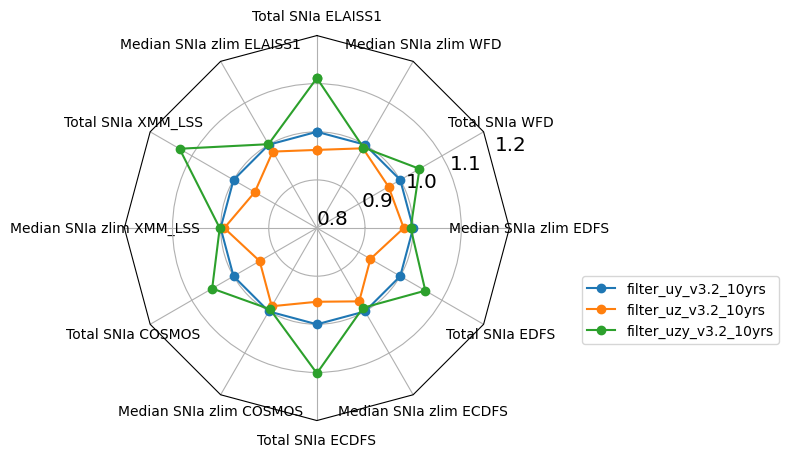

In [10]:
# Make radar plots, since there are only a few sims
# The scoc radar plot probably not 

[m for m in msets if 'DD' in m]
mset = metrics.loc['SNIa DDF']
mags = mset['mag'].values
zlims = [np.arange(1, len(mags), 4)]

mags[zlims] = True
msub = maf.create_metric_subset('SNIa DDF 2', mset['metric'], mset['short_name'], mset['invert'], mag = mags)
msub = msub.query('metric.str.contains("SN")')
msub = msub.loc['SNIa DDF 2']

normed = maf.normalize_metric_summaries(baseline, 
                                        summaries.loc[rr, msub['metric']],
                                        msub)
normed.columns = normed.columns.map(msub['short_name'])
normed

fig, ax = maf.radar(normed, rgrids=[0.8, 0.9, 1.0, 1.1, 1.2,], figsize=(6, 5), bbox_to_anchor=[1.7, 0.2])
fig.set_figwidth(8)
fig.set_figheight(5)
normed.loc[rr]
plt.savefig(os.path.join(outdir, 'filter_swap_SNIa.png'), bbox_inches='tight')

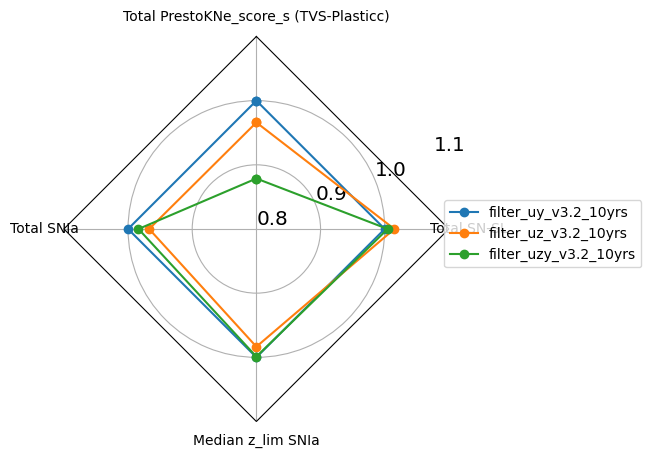

In [11]:
msub1 = metrics.loc['TVS KNe short'].query('~metric.str.contains("ztfrest")')
msub2 = metrics.loc['DESC WFD'].query('metric.str.contains("SN")')
msub = pd.concat([msub1, msub2])
#msub = pd.concat([mset, metric_sets.loc['TVS Gaps']])

normed = maf.normalize_metric_summaries(baseline, 
                                        summaries.loc[rr, msub['metric']],
                                        msub)
normed.columns = normed.columns.map(msub['short_name'])
normed

fig, ax = maf.radar(normed, rgrids=[0.8, 0.9, 1.0, 1.1,], figsize=(5, 5), bbox_to_anchor=[1.5, 0.4])
fig.set_figwidth(8)
fig.set_figheight(5)
normed.loc[rr]
plt.savefig(os.path.join(outdir, 'filter_swap_KNe.png'), bbox_inches='tight')

In effect:
* we see some changes in TVS fast transients that are not as good when we swap uzy as when we swap uz. This was due to shifting around on the order of 2-3 visits which could happen randomly, but is also what you might expect when you compress the cadence in $z$ band by only having it available during certain parts of the month (and KNe are bright in z). Given that $z$ has a lot of visits, we might want to look at taking some $z$ band visits to improve 24 hour sampling in that bandpass in particular. Also though -- uzy should still be better than uy, and it isn't.
* the SNIa metric had no obvious reason for doing better with uzy swaps -- if uy was better than uz, then surely uzy should be worse than uy. And indeed the SN sensitivity itself follows this rule, but because of how the scheduler reschedules missed visits in DDFs (including visits missed because of the filter availability), the uzy worked out better. This also could get reversed with a change in the DDF strategy or other code changes in the scheduler.
* in the end, the idea that z on a more regular cadence was better than having gaps won -- including the fact that swapping the z filter in and out of the camera was considered more risky. than swapping the y filter


## Comparison of u band exposures (Filter Balance)

Between v3.2 and v3.3 there was an update to the throughput curves (going from Al-Ag-Al to 3xAg mirror surfaces, plus some small updates in transmission for other surfaces to match updated measurements). These changes reduced throughput in u band noticeably, so consideration was made to modifying u band exposure time and/or number of visits to compensate for the changes in u band depth.

See https://github.com/lsst-pst/survey_strategy/blob/main/fbs_3.3/v3_3_Investigations_uband.ipynb and https://github.com/lsst-pst/survey_strategy/blob/main/fbs_3.4/v3_4_Investigations_uband.ipynb for the original notebooks.

In [12]:
# https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.4/maf/summary.h5
summaries_v34 = maf.get_metric_summaries(summary_source="fbs_3.4/summary_good.h5")
print(f"This file contains information on {len(summaries_v34)} simulations")
summaries_v33 = maf.get_metric_summaries(summary_source="fbs_3.4/summary_v3.3.h5")
print(f"This file contains information on {len(summaries_v33)} simulations")

# Join these two metric summary files - spot check indicated no changes in metric results where runs overlap
rr = [r for r in summaries_v33.index if r not in summaries_v34.index]
summaries = pd.concat([summaries_v34, summaries_v33.loc[rr]])

This file contains information on 273 simulations
This file contains information on 78 simulations


In [13]:
# u band variations
uband = [r for r in summaries.index if 'internal_u' in r and '60' not in r and '1.5' not in r]
uband_shortname = [f"u {r.split('expt')[-1].split('_')[0]}s {r.split('nscale')[-1].split('v3.4')[0]}" for r in uband]
uband +=  ['u_exp_othershort_38_other29_v3.3_10yrs', 'baseline_v3.2_10yrs', 'baseline_v3.3_10yrs',]
uband_shortname += ['u 38s 1*', 'v3.2', 'v3.3']
uband_dict = {}
for u, us in zip(uband, uband_shortname):
    uband_dict[u] = us
    print(u, '\t',  us)

runs = uband
rdict = uband_dict
baseline = 'internal_u_expt30_nscale1.0v3.4_10yrs'

internal_u_expt27_nscale0.9v3.4_10yrs 	 u 27s 0.9
internal_u_expt27_nscale1.0v3.4_10yrs 	 u 27s 1.0
internal_u_expt27_nscale1.1v3.4_10yrs 	 u 27s 1.1
internal_u_expt27_nscale1.2v3.4_10yrs 	 u 27s 1.2
internal_u_expt30_nscale0.9v3.4_10yrs 	 u 30s 0.9
internal_u_expt30_nscale1.0v3.4_10yrs 	 u 30s 1.0
internal_u_expt30_nscale1.1v3.4_10yrs 	 u 30s 1.1
internal_u_expt30_nscale1.2v3.4_10yrs 	 u 30s 1.2
internal_u_expt38_nscale0.9v3.4_10yrs 	 u 38s 0.9
internal_u_expt38_nscale1.0v3.4_10yrs 	 u 38s 1.0
internal_u_expt38_nscale1.1v3.4_10yrs 	 u 38s 1.1
internal_u_expt38_nscale1.2v3.4_10yrs 	 u 38s 1.2
internal_u_expt45_nscale0.9v3.4_10yrs 	 u 45s 0.9
internal_u_expt45_nscale1.0v3.4_10yrs 	 u 45s 1.0
internal_u_expt45_nscale1.1v3.4_10yrs 	 u 45s 1.1
internal_u_expt45_nscale1.2v3.4_10yrs 	 u 45s 1.2
u_exp_othershort_38_other29_v3.3_10yrs 	 u 38s 1*
baseline_v3.2_10yrs 	 v3.2
baseline_v3.3_10yrs 	 v3.3


In [14]:
weather_runs = [r for r in summaries_v34.index if "weather" in r]
dev = np.std(summaries_v34.loc[weather_runs], axis=0)
hilo = np.abs(summaries_v34.loc[weather_runs].max() - summaries_v34.loc[weather_runs].min())

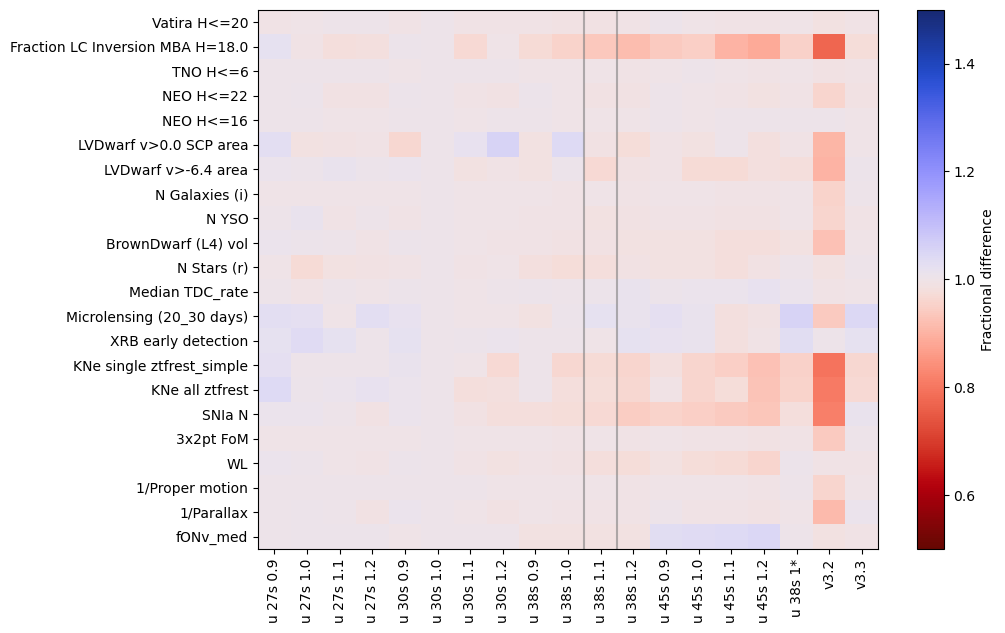

In [15]:
msub = metrics.loc['SCOC']

fig, ax = maf.plot_run_metric_mesh(summaries.loc[runs, msub['metric']], 
                     baseline_run=baseline,
                     metric_subset=msub,
                        metric_label_map=msub['short_name'],
                        run_label_map=rdict
                      )
ax.axvline(10, color='gray', alpha=0.6)
ax.axvline(11, color='gray', alpha=0.6)
fig.set_figheight(7)
fig.set_figwidth(10)
plt.savefig(os.path.join(outdir, 'u_band_scoc_heatmap.png'),  bbox_inches='tight')

## Rolling Cadence

Baseline_v3.0 used 3 cycles (1 'cycle' = one season of more intense coverage, followed by a season of less intense coverage) of rolling cadence, with about 1.5 years at the start and end of the survey in a uniform (non-rolling, standard cadence) mode.
Baseline_v3.2 increased the time spent rolling to 4 cycles, by pushing rolling into the last year of the survey. 

DESC have expressed concern that intermediate data releases will be significantly non-uniform due to rolling - no matter when the data release is, some part of the sky will be entering a rolling cycle, if rolling is uninterrupted once it starts. Thus a "uniform rolling" cadence has been introduced, which more or less amounts to:  
- season -1 == the first, non-complete visibility season for a field on the sky .. when the survey starts, there will be parts of the sky which have not been visible from the start of their season, and so these do not receive a full season. Seasons corresond to RA ranges.
- season 0 == the first full season a point on the sky will be observed. This needs to be observed uniformly so that we can build up catalogs over the whole sky.
- season 1 + 2 == the first cycle of rolling (whether the point on the sky is high intensity or low intensity depends on its declination, but over one cycle all of the sky will experience both high and low intensity)
- season 3 == the first uniform season, covering the entire sky uniformly .. this smooths out non-uniformities from rolling, but also creates the opportunity for a more uniform data release (this corresponds to year 4).
- season 4 + 5 / season 6 == the next cycle of rolling plus uniform
- season 7 + 8 / season 9 == the final cycle of rolling plus uniform
- season 10 (where applicable) -- a final partial season of uniform coverage

While uniform rolling produces more uniform data releases at year 4 and year 7 (DR5 and DR8), there is one fewer cycle of rolling than in baseline_v3.2

Variations on 3 cycles of rolling, 4 cycles of rolling, and 3 cycles of uniform rolling, as well as no rolling, were included in v3.4.
* https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.4/roll_uniform_early_half/
* https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.4/noroll/
* https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.4/roll_3/
* https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.4/baseline/

Some transient science metrics show a slight decrease with one less cycle of rolling, but these are metrics for discovering KNe. The yield in discovering KNe is low, so the metrics are noisy and there has been much discussion about the significance of the results. Looking at the number of times we sample the 3-48 hour timegaps is another way to investigate the problem, although it suffers from having sensitivity to a narrower range of timescales (i.e. timegaps for 7 hours are sensitive to visits spaced to sample about 4.5 - 7.5 hours but not beyond that, and phasing can be an additional problem). However, counting gap sampling is much higher snr than counting KNe discovery. 


In [16]:
## The gaps aren't currently measured at 24 and 48 hours per bandpass, in WFD area only .. 
## should add to MAF but for now, just calculate. 

sql = 'visitExposureTime > 18 and note not like "%DD%"'
info = 'wfd visits'
filterlist, colors, filterorders, filtersqls, filterinfo_label = maf.filter_list(all=True, extra_sql=sql, extra_info_label=info)

footprints, labels = get_current_footprint(nside=64)
wfdhpid = np.where((labels == 'lowdust') | (labels == "euclid_overlap") | (labels == "LMC_SMC") | (labels == "virgo"))[0]
wfd_slicer = maf.HealpixSubsetSlicer(nside=64, hpid=wfdhpid)

ngaps = {}
for opsim in ['noroll_mjdp0_v3.4_10yrs', 'baseline_v3.3_10yrs', 'baseline_v3.4_10yrs', 'roll_3_v3.4_10yrs', 'roll_uniform_early_half_mjdp0_v3.4_10yrs']:

    ngaps[opsim] = {}
    
    for f in filterlist:
        
        gaps = [3.0, 7.0, 24.0, 24.0*2, 24.0*3, 24.0*4]
        for gap in gaps:
            summary_stats = []
            summary_stats.append(
                maf.AreaSummaryMetric(
                    area=18000,
                    reduce_func=np.median,
                    decreasing=True,
                    metric_name="Median N gaps in %s at %ihr in top 18k" % (f, gap),
                )
            )
    
            summary_stats.append(
                maf.AreaSummaryMetric(
                    area=18000,
                    reduce_func=np.mean,
                    decreasing=True,
                    metric_name="Mean N gaps in %s at %ihr in top 18k" % (f, gap),
                )
            )
    
            summary_stats.append(maf.MeanMetric())
            summary_stats.append(maf.MedianMetric())
    
            m2 = maf.GapsMetric(
                time_scale=gap,
                metric_name="Gaps_%ihr" % gap,
            )
            plotFuncs = [maf.HealpixSkyMap(), maf.HealpixHistogram()]
            plotDict = {"color_min": 0, "color": colors[f], "percentile_clip": 95}
            ngaps[opsim][f"{f}_{gap :.1f}"] = (
                maf.MetricBundle(
                    m2,
                    wfd_slicer,
                    constraint=filtersqls[f],
                    info_label=filterinfo_label[f],
                    run_name=opsim,
                    summary_metrics=summary_stats,
                    plot_dict=plotDict,
                    plot_funcs=plotFuncs,
                )
            )

try_read = try_read_default
if try_read:
    for opsim in ngaps:
        for n in ngaps[opsim]:
            ngaps[opsim][n].read(os.path.join(outdir, ngaps[opsim][n].file_root + ".npz"))

else:
    for opsim in ngaps:
        if opsim.startswith('b'):
            opsimdb = f'{opsim}.db'
        else:
            opsimdb = f'fbs_3.4/{opsim}.db'
        gg = maf.MetricBundleGroup(ngaps[opsim], opsimdb, out_dir=outdir, verbose=False)
        gg.run_all()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

In [17]:
# Seems like summary stats didn't get saved 
for opsim in ngaps:
    for f in filterlist:
        gaps = [3.0, 7.0, 24.0, 24.0*2, 24.0*3, 24.0*4]
        for gap in gaps:
            k = f"{f}_{gap :.1f}"
            summary_stats = []
            summary_stats.append(
                maf.AreaSummaryMetric(
                    area=18000,
                    reduce_func=np.median,
                    decreasing=True,
                    metric_name="Median N gaps in %s at %ihr in top 18k" % (f, gap),
                )
            )
    
            summary_stats.append(
                maf.AreaSummaryMetric(
                    area=18000,
                    reduce_func=np.mean,
                    decreasing=True,
                    metric_name="Mean N gaps in %s at %ihr in top 18k" % (f, gap),
                )
            )
    
            summary_stats.append(maf.MeanMetric())
            summary_stats.append(maf.MedianMetric())
            ngaps[opsim][k].set_summary_metrics(summary_stats)
            ngaps[opsim][k].compute_summary_stats()

In [18]:
# Gather up summary stats for these tgaps
dd = {}
for o in ngaps:
    dd[o] = {}
    for k in ngaps[o]:
        dd[o][k] = ngaps[o][k].summary_values['Mean']
pp = pd.DataFrame(dd)
pp.T.to_hdf(os.path.join(outdir, 'more_gaps.h5'), key='stats')

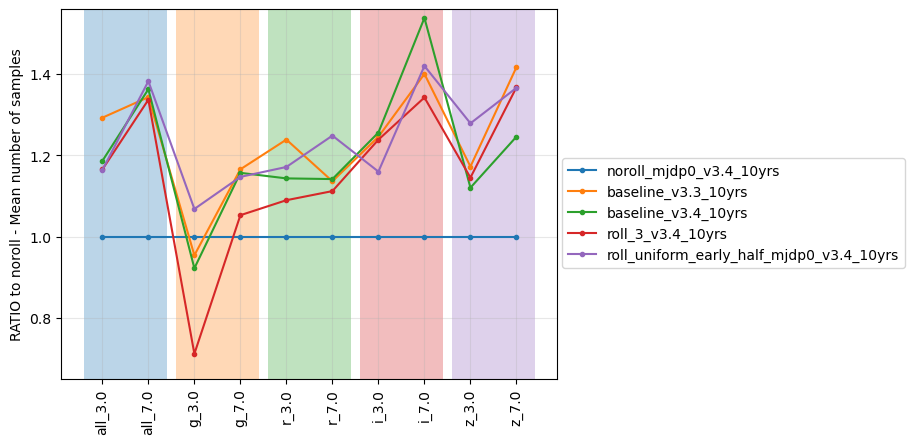

In [19]:
# Plot ratios of the summaries
keys = [f"{f}_{g}" for f in ['all', 'g', 'r','i', 'z'] for g in [3.0, 7.0]]
tt = (pp.T[keys]/ pp.T.loc['noroll_mjdp0_v3.4_10yrs', keys])
for opsim in ngaps:
    _ = plt.plot(keys, tt.loc[opsim, keys], marker='.', label=opsim)
step = 2
for x in np.arange(0, 10, step):
    plt.fill_between([x-0.4, x+step-0.6], 0, 150, alpha=0.3) 
plt.legend(loc=(1.01, 0.3))
plt.ylim(0.65, 1.56)
#plt.ylim(0, 5)
_ = plt.xticks(rotation='vertical')
plt.grid(True, alpha=0.3)
plt.ylabel("RATIO to noroll - Mean number of samples")
pp.T[keys]
plt.savefig(os.path.join(outdir, 'ratios_3hr_gaps.png'), bbox_inches='tight')

No significant signal in terms of sensitivity to number of cycles of rolling when sampling 3-7 hour timegaps. This is in line with expectations, that this sampling should be primarily controlled by the triplets microsurvey. 

all_24.0    all_48.0    all_72.0  \
noroll_mjdp0_v3.4_10yrs                    86.361677   84.929472  104.518443   
baseline_v3.3_10yrs                       113.563346  111.332252  123.701946   
baseline_v3.4_10yrs                       113.333503  111.764782  123.506627   
roll_3_v3.4_10yrs                         108.123587  105.715524  119.086840   
roll_uniform_early_half_mjdp0_v3.4_10yrs  106.981279  105.443513  118.061260   

                                            all_96.0    g_24.0    g_48.0  \
noroll_mjdp0_v3.4_10yrs                   117.160890  2.553429  2.821084   
baseline_v3.3_10yrs                       131.847915  3.137396  3.812651   
baseline_v3.4_10yrs                       131.483411  3.555051  3.854495   
roll_3_v3.4_10yrs                         128.633272  3.450788  3.775162   
roll_uniform_early_half_mjdp0_v3.4_10yrs  127.215107  3.267006  3.632715   

                                            g_72.0    g_96.0     r_24.0  \
noroll_mjdp0_v3.4_10yrs                   4.135635  4.825348  14.779472   
baseline_v3.3_10yrs                       5.213485  5.795459  19.853985   
baseline_v3.4_10yrs                       5.235449  5.958573  21.556580   
roll_3_v3.4_10yrs                         5.209500  6.147915  20.074143   
roll_uniform_early_half_mjdp0_v3.4_10yrs  5.017285  5.691196  20.386701   

                                             r_48.0     r_72.0     r_96.0  \
noroll_mjdp0_v3.4_10yrs                   15.349583  22.177108  25.655514   
baseline_v3.3_10yrs                       20.495644  28.120760  31.349629   
baseline_v3.4_10yrs                       21.955005  28.940454  32.171131   
roll_3_v3.4_10yrs                         20.618072  28.097451  31.638879   
roll_uniform_early_half_mjdp0_v3.4_10yrs  20.458573  27.529286  30.616682   

                                             i_24.0     i_48.0     i_72.0  \
noroll_mjdp0_v3.4_10yrs                   13.431047  12.253522  18.186237   
baseline_v3.3_10yrs                       18.749259  18.299259  25.094810   
baseline_v3.4_10yrs                       18.610009  18.937442  25.747312   
roll_3_v3.4_10yrs                         18.038971  17.510241  24.531511   
roll_uniform_early_half_mjdp0_v3.4_10yrs  17.573818  17.362419  23.826830   

                                             i_96.0     z_24.0     z_48.0  \
noroll_mjdp0_v3.4_10yrs                   21.504773  13.202966  11.186330   
baseline_v3.3_10yrs                       28.263068  16.325672  15.450880   
baseline_v3.4_10yrs                       29.217980  17.579240  15.898610   
roll_3_v3.4_10yrs                         27.818211  16.287257  14.559314   
roll_uniform_early_half_mjdp0_v3.4_10yrs  27.004171  16.629240  14.438786   

                                             z_72.0     z_96.0  
noroll_mjdp0_v3.4_10yrs                   14.975533  16.467980  
baseline_v3.3_10yrs                       19.720714  21.737998  
baseline_v3.4_10yrs                       20.486886  22.500788  
roll_3_v3.4_10yrs                         19.148146  21.110056  
roll_uniform_early_half_mjdp0_v3.4_10yrs  18.361863  20.271084

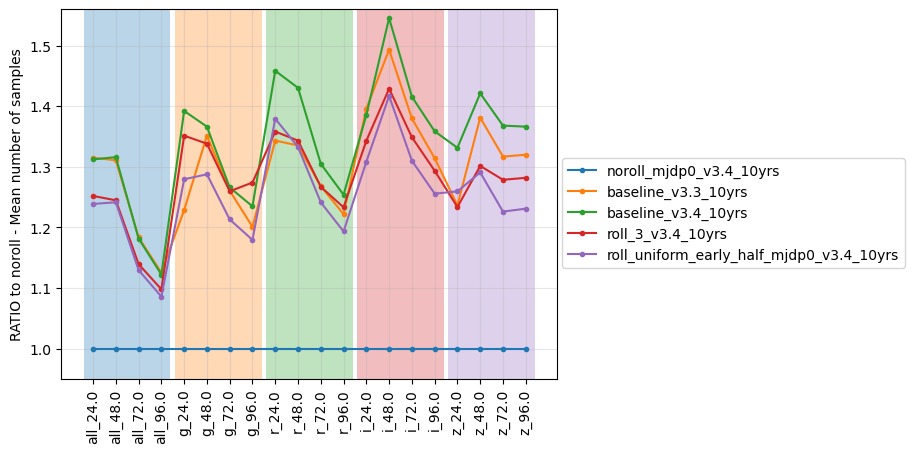

In [20]:
# Plot ratios of the summaries
keys = [f"{f}_{g}" for f in ['all', 'g', 'r','i', 'z'] for g in [24.0, 48.0, 72.0, 96.0] ]
tt = (pp.T[keys]/ pp.T.loc['noroll_mjdp0_v3.4_10yrs', keys])
for opsim in ngaps:
    _ = plt.plot(keys, tt.loc[opsim, keys], marker='.', label=opsim)
step = 4
for x in np.arange(0, 20, step):
    plt.fill_between([x-0.4, x+step-0.6], 0, 150, alpha=0.3) 
plt.legend(loc=(1.01, 0.3))
plt.ylim(0.95, 1.56)
#plt.ylim(0, 35)
_ = plt.xticks(rotation='vertical')
plt.grid(True, alpha=0.3)
plt.ylabel("RATIO to noroll - Mean number of samples")
plt.savefig(os.path.join(outdir, 'ratios_24hr_gaps.png'), bbox_inches='tight')
pp.T[keys]

In [21]:
x = 86.3/10
low = 0.3
hi = 2.5
# predict the number of samples at 24 hours, given rolling cycles
print(10*x, (2*x + 4*x*hi + 4*x*low), (4*x + 3*x*hi +3*x*low)) 
# predict the improvement from one rolling cycle, compared to uniform
(hi * x + low *x) / 2 * x

86.29999999999998 113.91599999999997 107.01199999999999


104.26765999999996

Here we see that the number of cycles of rolling is reflected in the number of samples of 24 and 48 hour gaps.
Even without any rolling cadence, there is *some* sampling of 24 hour gaps, so the difference between 3 and 4 cycles is not expected to be 25%. Instead we see about 5% difference, most clearly when looking at 'all' filters. 

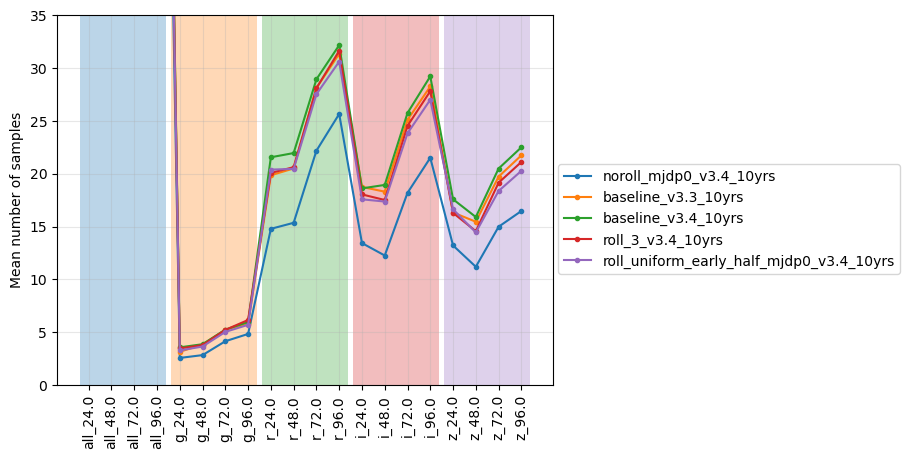

In [22]:
# Plot ratios of the summaries
keys = [f"{f}_{g}" for f in ['all', 'g', 'r','i', 'z'] for g in [24.0, 48.0, 72.0, 96.0] ]
tt = (pp.T[keys]) # / pp.T.loc['noroll_mjdp0_v3.4_10yrs', keys])
for opsim in ngaps:
    _ = plt.plot(keys, tt.loc[opsim, keys], marker='.', label=opsim)
step = 4
for x in np.arange(0, 20, step):
    plt.fill_between([x-0.4, x+step-0.6], 0, 150, alpha=0.3) 
plt.legend(loc=(1.01, 0.3))
plt.ylim(0.95, 1.56)
plt.ylim(0, 35)
_ = plt.xticks(rotation='vertical')
plt.grid(True, alpha=0.3)
plt.ylabel("Mean number of samples")
plt.savefig(os.path.join(outdir, 'mean_24hr_gaps.png'), bbox_inches='tight')

Plot the footprint at year 4 with four cycle, no, and uniform rolling strategies.

In [23]:
# Footprint at year 4 
# use v3.6
m = maf.CountMetric('observationStartMJD', metric_name='Nvisits')
s = maf.HealpixSlicer(nside=64)
constraint = "night < 365.25*4"

try_read = try_read_default

bundle = {}
for opsdb in ['baseline_v3.4_10yrs.db', 'noroll_mjdp0_v3.4_10yrs.db', 'roll_uniform_early_half_mjdp0_v3.4_10yrs.db']:
    run_name = opsdb.replace('.db', '').replace('mjdp0', '').replace("_10yrs", '').replace('__', '_').replace('_', ' ')
    print(run_name)
    conn = os.path.join('fbs_3.4', opsdb)
    bundle[run_name] = maf.MetricBundle(m, s, constraint, run_name=run_name, info_label = 'Year 4')
    if try_read:
        bundle[run_name].read(os.path.join(outdir, bundle[run_name].file_root + '.npz'))
    else:
        g = maf.MetricBundleGroup({'run_name': bundle[run_name]}, conn, out_dir=outdir)
        g.run_all()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
baseline v3.4
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
noroll v3.4
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
roll uniform early half v3.4
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


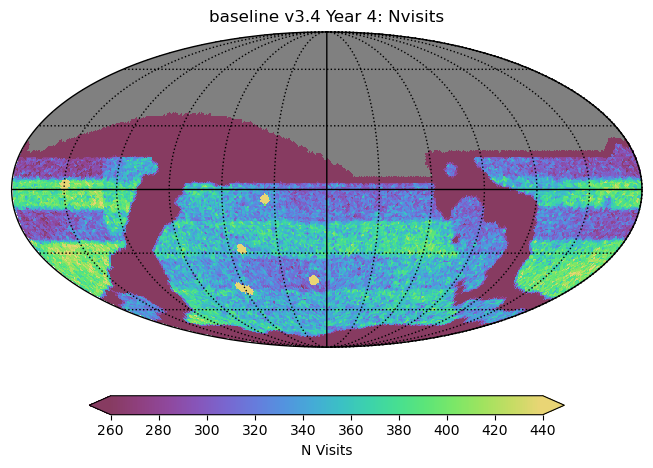

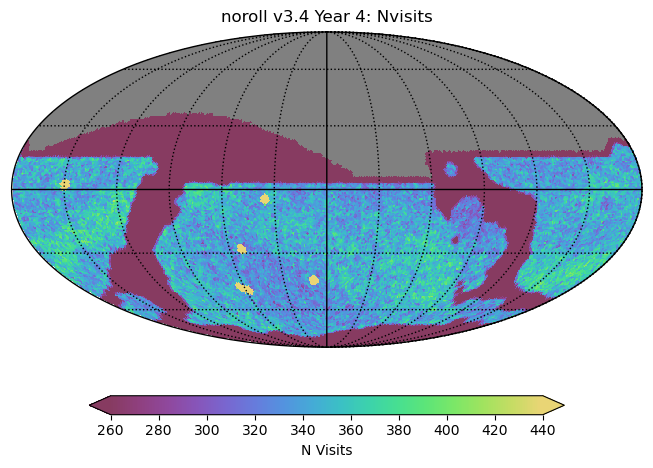

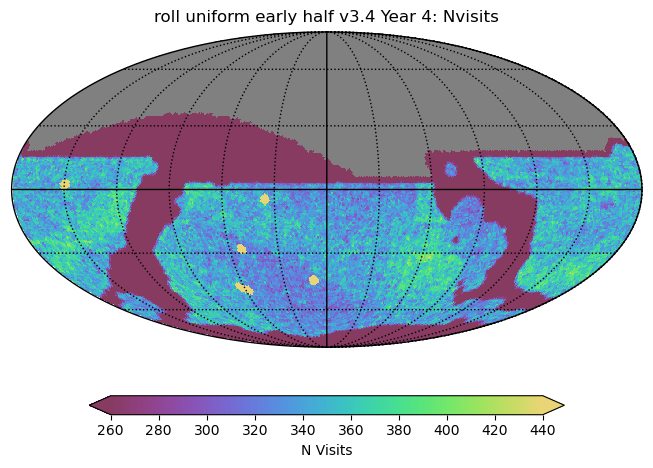

In [24]:
for b in bundle:
    ph.set_metric_bundles([bundle[b]])
    fig  = ph.plot(maf.HealpixSkyMap(), plot_dicts={'color_min': 260, 'color_max': 440, 'extend': 'both', 'xlabel': "N Visits"})

## Metric comparison of baselines

Standard SCOC heatmap plot

In [25]:
# https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.6/maf/summary.h5
summaries_v40 = maf.get_metric_summaries(summary_source="fbs_4.0/summary.h5")
print(f"This file contains information on {len(summaries_v40)} simulations")

summaries_v36 = maf.get_metric_summaries(summary_source="fbs_3.6/summary.h5")
print(f"This file contains information on {len(summaries_v36)} simulations")

# https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.5/maf/summary.h5
summaries_v35 = maf.get_metric_summaries(summary_source="fbs_3.5/summary_v3.5.h5")
print(f"This file contains information on {len(summaries_v35)} simulations")

This file contains information on 14 simulations
This file contains information on 16 simulations
This file contains information on 35 simulations


In [26]:
# Joint v35 v36 v40
tt = summaries_v35.loc[[r for r in summaries_v35.index if r not in summaries_v40.index]]
summaries = pd.concat([summaries_v40, tt])
tt = summaries_v36.loc[[r for r in summaries_v36.index if r not in summaries.index]]
summaries = pd.concat([summaries, tt])
summaries.index #summaries.loc[:, metrics.loc['SCOC']['metric']]

Index(['baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
       'baseline_v3.0_10yrs', 'baseline_v3.2_10yrs', 'baseline_v3.3_10yrs',
       'baseline_v3.4_10yrs', 'baseline_v3.5_10yrs', 'baseline_v3.6_10yrs',
       'baseline_v4.0_10yrs', 'four_cycle_v4.0_10yrs', 'no_too_v4.0_10yrs',
       'one_snap_v4.0_10yrs', 'retro_baseline_v2.0_10yrs', 'acord_v3.5_10yrs',
       'ddf_agn_v3.5_10yrs', 'ddf_low_dither_v3.5_10yrs',
       'ddf_roll_deep_v3.5_10yrs', 'ddf_roll_v3.5_10yrs',
       'four_cycle_v3.5_10yrs', 'one_snap_v3.5_10yrs',
       'telescope_jerk_downtimes_v3.5_10yrs', 'telescope_jerk_v3.5_10yrs',
       'too_v3.5_10yrs', 'weather_cloudso0v3.5_10yrs',
       'weather_cloudso10v3.5_10yrs', 'weather_cloudso12v3.5_10yrs',
       'weather_cloudso14v3.5_10yrs', 'weather_cloudso16v3.5_10yrs',
       'weather_cloudso18v3.5_10yrs', 'weather_cloudso1v3.5_10yrs',
       'weather_cloudso20v3.5_10yrs', 'weather_cloudso2v3.5_10yrs',
       'weather_cloudso30v3.5_10yrs', 'wea

In [27]:
baseline_dict = {'retro_baseline_v2.0_10yrs': 'v1.x', 
                 'baseline_v2.0_10yrs':'v2.0', 
                 #'baseline_v2.1_10yrs':'v2.1',
                 #'baseline_v2.2_10yrs':'v2.2',
                 'baseline_v3.0_10yrs':'v3.0',
                 'baseline_v3.2_10yrs':'v3.2',
                'baseline_v3.3_10yrs':'v3.3',
                'baseline_v3.4_10yrs': 'v3.4',
                'baseline_v3.5_10yrs': 'v3.5',
                 #'too_v3.5_10yrs': 'v3.5+ToO',
                 'baseline_v3.6_10yrs': 'v3.6',
                 'no_too_v3.6_10yrs': 'no_too v3.6',
                }

newbaselines_dict = {'baseline_v4.0_10yrs': 'baseline v4.0',
                     'four_cycle_v4.0_10yrs': 'four cycle v4.0',
                     #'no_too_v4.0_10yrs': 'NoToO v4.0',
                     'one_snap_v4.0_10yrs': 'one snap v4.0'
                    }

rdict = {}
for k in baseline_dict:
    rdict[k] = baseline_dict[k]
for k in newbaselines_dict:
    rdict[k] = newbaselines_dict[k]

runs = list(rdict.keys())
baseline = 'baseline_v4.0_10yrs'

In [28]:
wsummaries = summaries_v35
weather_runs = [r for r in wsummaries.index if "weather" in r]
dev = np.std(wsummaries.loc[weather_runs], axis=0)
hilo = np.abs(wsummaries.loc[weather_runs].max() - wsummaries.loc[weather_runs].min())
len(weather_runs)

16

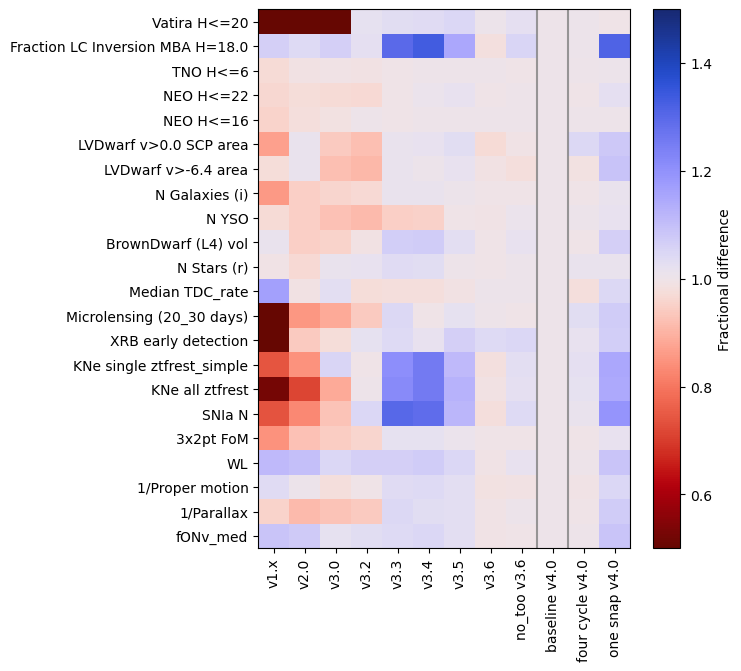

In [29]:
msub = metrics.loc['SCOC']

fig, ax = maf.plot_run_metric_mesh(summaries.loc[runs, msub['metric']], 
                     baseline_run=baseline,
                     metric_subset=msub,
                        metric_label_map=msub['short_name'],
                        run_label_map=rdict
                      )
ax.axvline(9, color='gray', alpha=0.8)
ax.axvline(10, color='gray', alpha=0.8)
fig.set_figheight(7)
plt.savefig(os.path.join(outdir, 'scoc_heatmap.png'),  bbox_inches='tight')

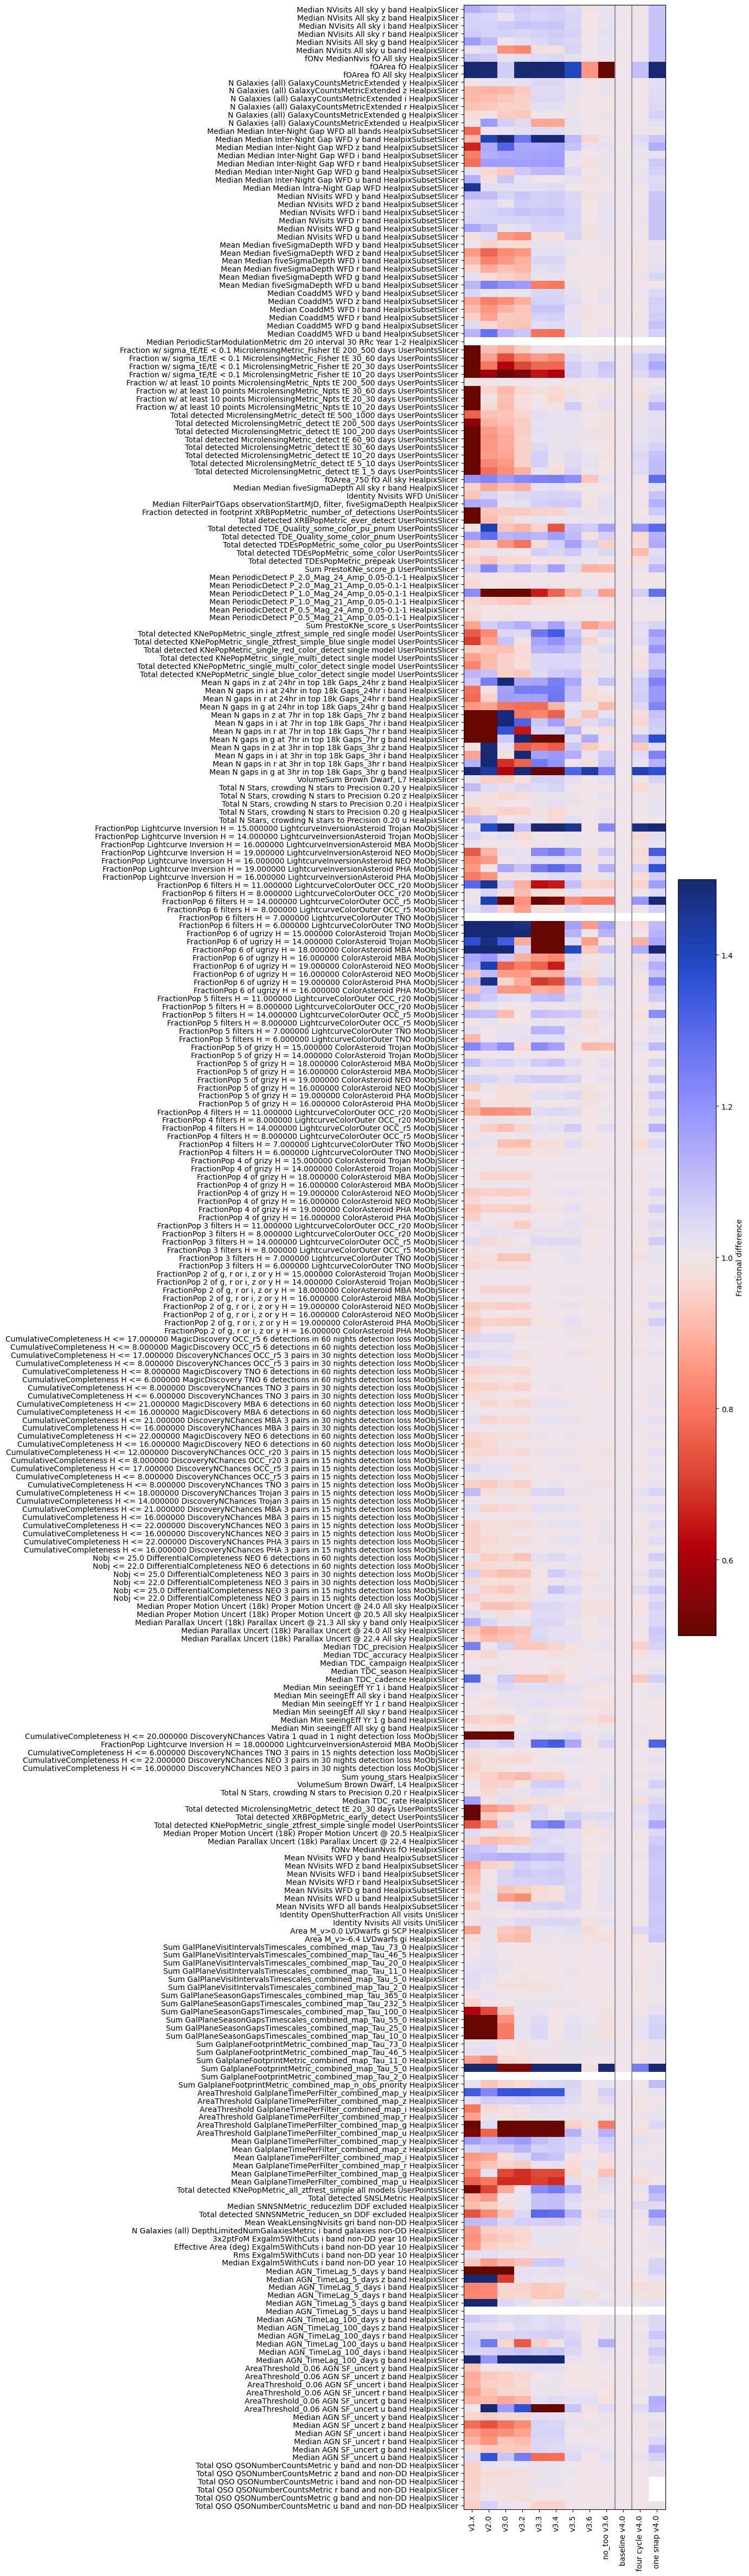

In [30]:
# Plot all the metrics, resulting in a very big and messy plot. Look at overall trends, or for things to investigate further.
non_dd = [m for m in msets if 'DD' not in m]
msub = metrics.loc[non_dd].reset_index(drop=True).drop('style', axis=1).drop('short_name', axis=1)
msub = msub.drop_duplicates().set_index('metric', drop=False, verify_integrity=True)

fig, ax = maf.plot_run_metric_mesh(summaries.loc[runs, msub['metric']], 
                     baseline_run=baseline,
                     metric_subset=msub,
                        run_label_map=rdict
                      )
ax.axvline(9, color='gray', alpha=0.8)
ax.axvline(10, color='gray', alpha=0.8)
fig.set_figheight(60)
plt.savefig(os.path.join(outdir, 'all_metrics_heatmap.png'),  bbox_inches='tight')

In [31]:
visits = ['Identity Nvisits All visits UniSlicer', 'Identity Nvisits DDF UniSlicer']
fraction = pd.DataFrame(summaries.loc[runs, visits[1]] / summaries.loc[runs, visits[0]],
                       columns=["Fraction of DDF visits per run"])
(fraction).round(4)

Fraction of DDF visits per run
run                                                      
retro_baseline_v2.0_10yrs                          0.0454
baseline_v2.0_10yrs                                0.0452
baseline_v3.0_10yrs                                0.0637
baseline_v3.2_10yrs                                0.0631
baseline_v3.3_10yrs                                0.0606
baseline_v3.4_10yrs                                0.0608
baseline_v3.5_10yrs                                0.0665
baseline_v3.6_10yrs                                0.0689
no_too_v3.6_10yrs                                  0.0680
baseline_v4.0_10yrs                                0.0686
four_cycle_v4.0_10yrs                              0.0686
one_snap_v4.0_10yrs                                0.0635

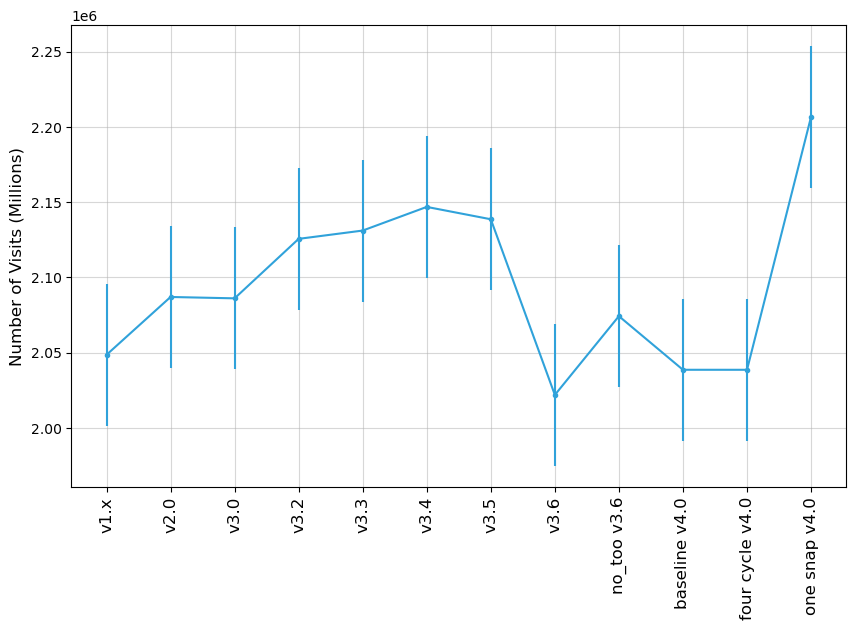

In [32]:
cols = [m for m in summaries if "Nvisits" in m and "UniSlicer" in m and 'All' in m]
cols

fig, ax = maf.plot_run_metric_uncert(summaries.loc[runs, cols],
                                 dev[cols],
                                 run_label_map=rdict)
ax.set_ylabel(f"Number of Visits (Millions)", fontsize='large')
leg = ax.get_legend()
leg.remove()
fig.savefig(os.path.join(outdir, 'total_nvisits.png'), format='png', bbox_inches='tight')

An illustrative metric improved by the filter throughputs at v3.3

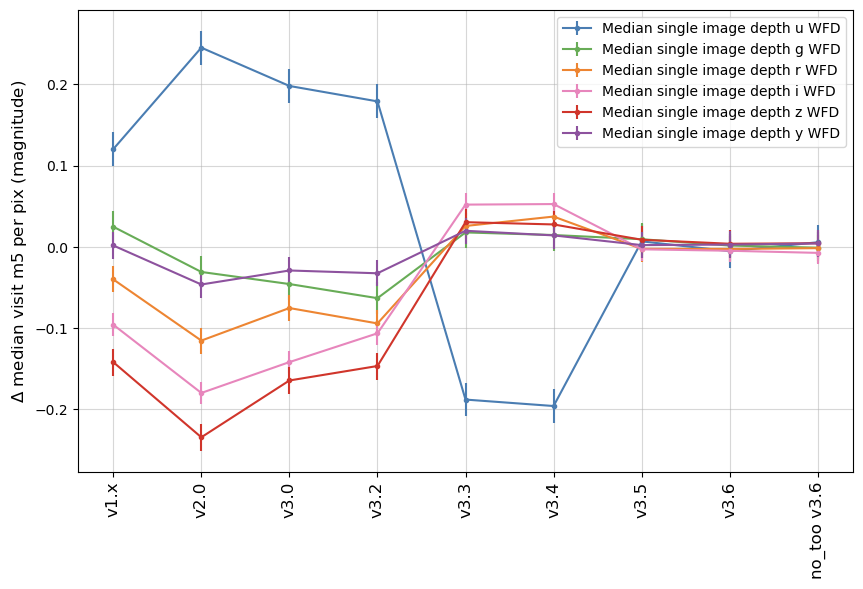

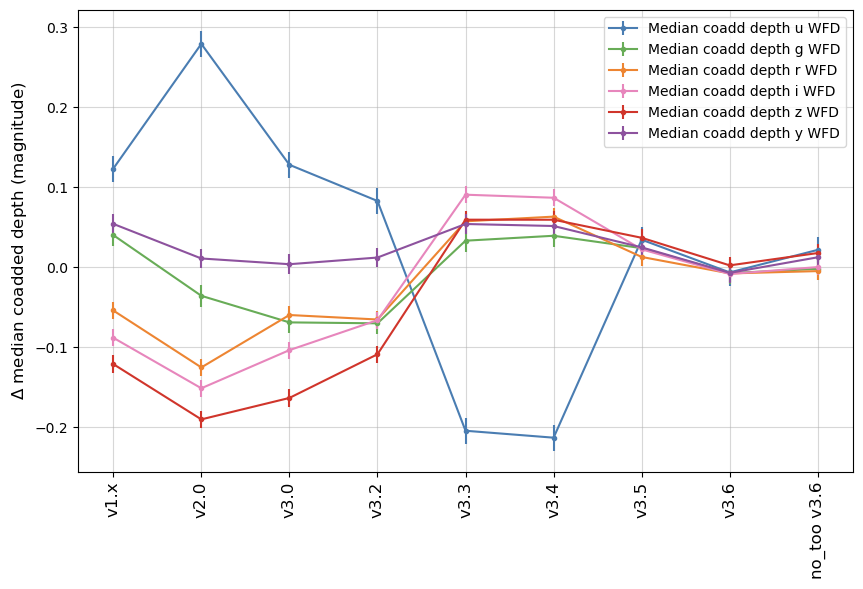

In [33]:
# illustration of single-visit and coadd-depth 

k = 'WFD Depths'

rr = runs[0:-3]
rrdict = {}
for r in rr:
    rrdict[r] = rdict[r]
rrdict['baseline_v3.6_10yrs'] = 'v3.6'

msub = metrics.loc[k].query('metric.str.contains("Mean Median")')
fig, ax = maf.plot_run_metric_uncert(summaries.loc[rr, msub['metric']] - summaries.loc[baseline, msub['metric']], 
                                 dev[msub['metric']], 
                                 metric_label_map=msub['short_name'], 
                                 run_label_map=rrdict,
                                 metric_subset=msub,
                                 cmap=filter_color_map,
                                 sep_plots=False)
ax.set_ylabel("$\Delta$ median visit m5 per pix (magnitude)", fontsize='large')
y1, y2 = plt.ylim()
fig.savefig(os.path.join(outdir, 'visit_m5_per_pix' + '.png'), format='png')

msub = metrics.loc[k].query('metric.str.contains("Coadd")')
fig, ax = maf.plot_run_metric_uncert(summaries.loc[rr, msub['metric']] - summaries.loc[baseline, msub['metric']], 
                                 dev[msub['metric']], 
                                 metric_label_map=msub['short_name'], 
                                 run_label_map=rrdict,
                                 metric_subset=msub,
                                 cmap=filter_color_map,
                                 sep_plots=False)
ax.set_ylabel("$\Delta$ median coadded depth (magnitude)", fontsize='large')
y1, y2 = plt.ylim()
fig.savefig(os.path.join(outdir, 'coadd_m5_per_pix' + '.png'), format='png')

In [34]:
maf.ParallaxMetric().units

'mas'

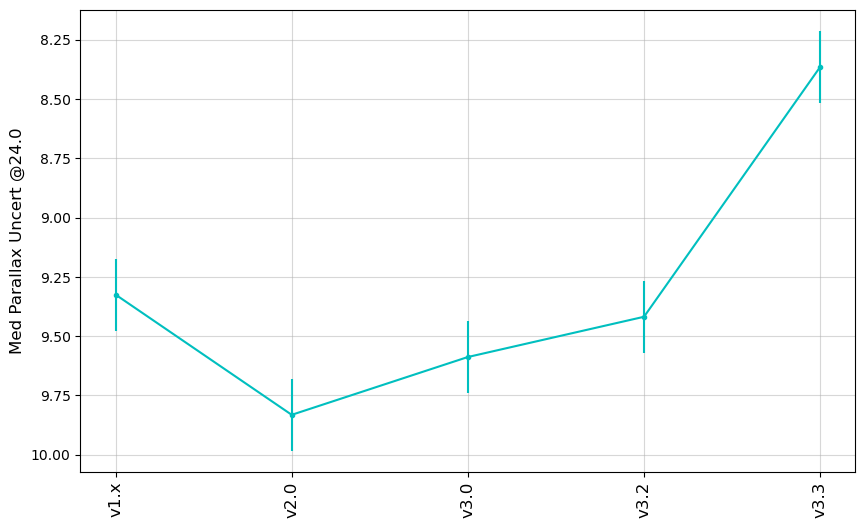

In [35]:
msub = metrics.loc['SRD'].query('metric.str.contains("Parallax")').query('metric.str.contains("24.0")')
rr = runs[0:5]

fig, ax = maf.plot_run_metric_uncert(summaries.loc[rr, msub['metric']], 
                                 dev[msub['metric']], 
                                 metric_label_map=msub['short_name'], 
                                 run_label_map=rdict,
                                 metric_subset=msub,)
leg = ax.get_legend()
leg.remove()
fig.savefig(os.path.join(outdir, 'baseline_parallax.png'), bbox_inches='tight')

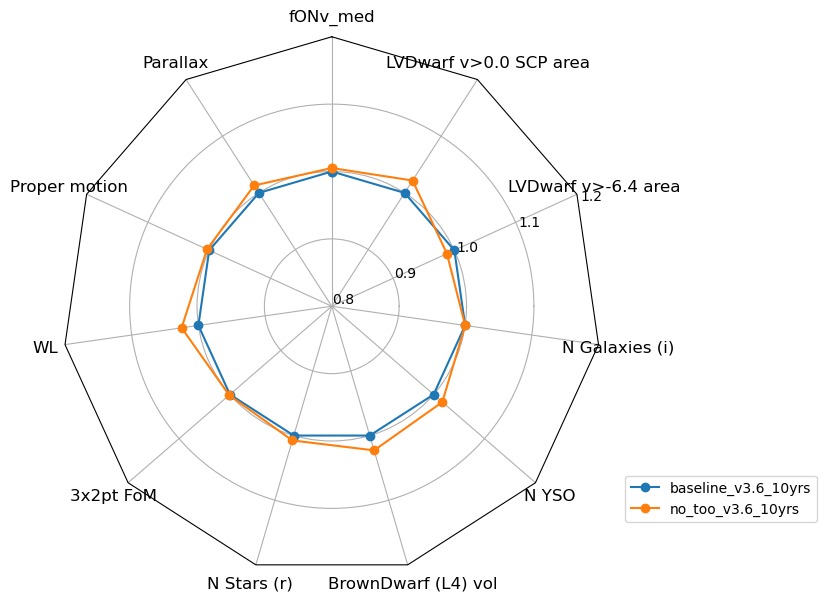

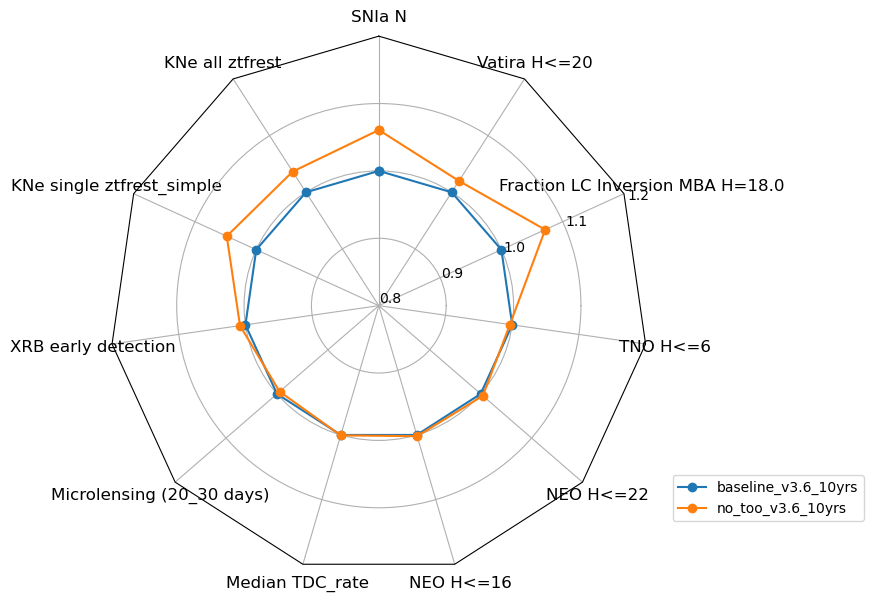

In [36]:
rr = ['baseline_v3.6_10yrs', 'no_too_v3.6_10yrs']
baseline = 'baseline_v3.6_10yrs'

msub = metrics.loc['SCOC']

statics = np.array([0, 1, 2, 3, 4, 11, 12, 13, 14, 15, 16])
variable = [i for i in np.arange(0, len(msub)) if i not in statics]

mset_stat = msub.iloc[statics]
mset_var = msub.iloc[variable]

normed = maf.normalize_metric_summaries(baseline,
                                        summaries.loc[rr, mset_stat['metric']],
                                        msub)
normed.columns = normed.columns.map(msub['short_name'])
normed

fig, ax = maf.radar(normed, rgrids=[0.80, 0.9, 1.0, 1.1, 1.2], figsize=(8, 8), bbox_to_anchor=[1.4, 0.1])
ax.tick_params(axis='x', labelsize='large')
ax.tick_params(axis='y', labelsize='medium')
fig.set_figwidth(8)
fig.set_figheight(7)
plt.savefig(os.path.join(outdir, 'baseline_v36_wfd_static.png'), bbox_inches='tight')

normed = maf.normalize_metric_summaries(baseline,
                                        summaries.loc[rr, mset_var['metric']],
                                        msub)
normed.columns = normed.columns.map(msub['short_name'])
normed

fig, ax = maf.radar(normed, rgrids=[0.8, 0.9, 1.0, 1.1, 1.2,], figsize=(8, 8), bbox_to_anchor=[1.4, 0.1])
ax.tick_params(axis='x', labelsize='large')
ax.tick_params(axis='y', labelsize='medium')
fig.set_figwidth(8)
fig.set_figheight(7)
normed.loc[rr]
plt.savefig(os.path.join(outdir, 'baseline_v36_wfd_transient.png'), bbox_inches='tight')

## Footprint plots

Make some plots of the footprint and distribution in various filters.

In [37]:
opsdb = 'fbs_4.0/baseline_v4.0_10yrs.db'
run_name = os.path.split(opsdb)[-1].replace('.db', '')


filterlist, colors, orders, sqls, infos = maf.filter_list(all=True)
bundles = {}
metric = maf.CountMetric('observationStartMJD', metric_name='NVisits')
slicer = maf.HealpixSlicer(nside=64)
for f in filterlist:
    if f == "all":
        colormax = 1000
    elif f in ('u', 'g'):
        colormax = 100
    else:
        colormax = 250
    plot_dict = {'color_min': 0, 'color_max': colormax, 'extend': 'max', 'color': colors[f]}
    plot_funcs = [maf.HealpixSkyMap(),]
    bundles[f] = maf.MetricBundle(metric, slicer, sqls[f], run_name=run_name, 
                              plot_dict=plot_dict, plot_funcs=plot_funcs, info_label=infos[f])

try_read = try_read_default
if try_read:
    for b in bundles:
        bundles[b].read(os.path.join(outdir, bundles[b].file_root + ".npz"))
else:
    g = maf.MetricBundleGroup(bundles, opsdb, out_dir=outdir, verbose=True)
    g.run_all()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [38]:
bundle_new = copy.deepcopy(bundles['all'])

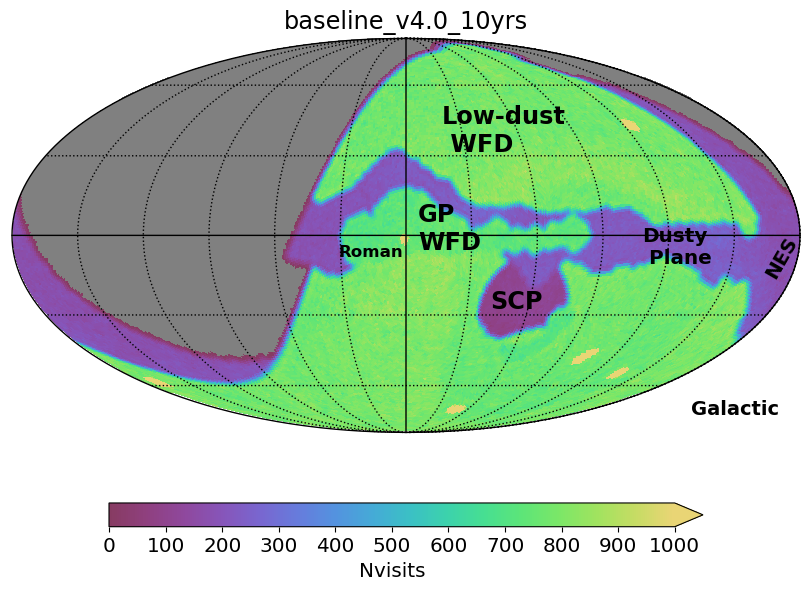

In [39]:
# Galactic plane orientation / footprint 

ph.set_metric_bundles([bundles['all']])
ph.plot(plot_func=maf.plots.HealpixSkyMap(),
        plot_dicts={'color_min': 0, 'color_max':1000, 'figsize': (8, 7),
                   'labelsize': 'x-large', 'fontsize':'x-large', 'xlabel': "Nvisits", 
                    'extend': 'max', 'coord': ["C", "G"]})
plt.figtext(0.55, 0.65, 'Low-dust\n WFD', fontsize='xx-large', fontweight='bold', color='black')
plt.figtext(0.95, 0.47, 'NES', fontsize='x-large', rotation=60, fontweight='bold', color='black')
#plt.figtext(0.9, 0.62, "Virgo",  fontsize='large', fontweight='bold', color='black')
plt.figtext(0.52, 0.51, 'GP\nWFD', fontsize='xx-large', fontweight='bold', color='black')
plt.figtext(0.42, 0.50, 'Roman', fontsize='large', rotation=0, fontweight='bold', color='black')
plt.figtext(0.80, 0.49, 'Dusty\n Plane', fontsize='x-large', rotation=0, fontweight='bold', color='black')
plt.figtext(0.61, 0.425, 'SCP', fontsize='xx-large', fontweight='bold', color='black')
#plt.figtext(0.36, 0.38, 'DDFs', fontsize='x-large', fontweight='bold', color='black')
plt.title(f'{run_name}', fontsize='xx-large', fontweight='normal')
# We have to save the figure separately, because otherwise labels aren't getting saved.
plt.savefig(os.path.join(outdir, f'{run_name.replace(".", "_")}_nvisits_galactic.{figformat}' ), 
            facecolor='w', edgecolor='w', bbox_inches='tight',dpi=270, format=figformat)

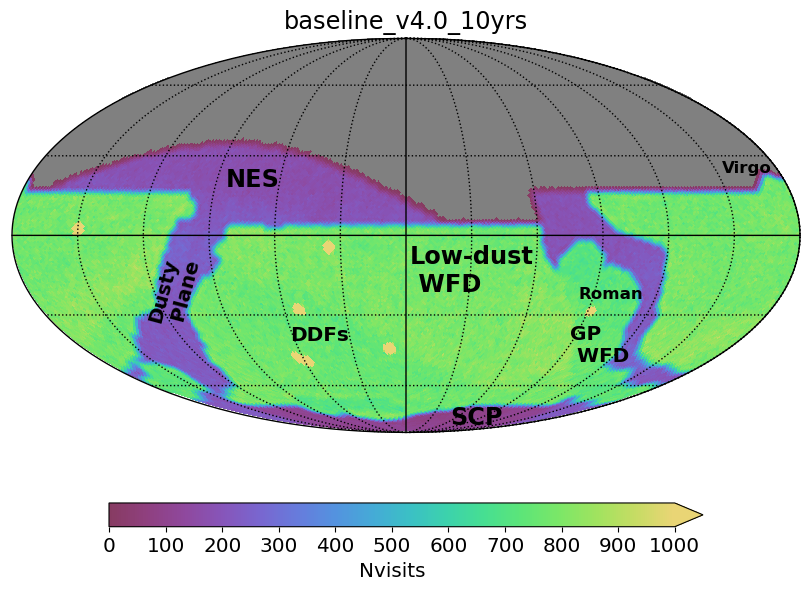

In [40]:
# General overview

ph.set_metric_bundles([bundles['all']])
ph.plot(plot_func=maf.plots.HealpixSkyMap(),
        plot_dicts={'color_min': 0, 'color_max':1000, 'figsize': (8, 7),
                   'labelsize': 'x-large', 'fontsize':'x-large', 'xlabel': "Nvisits", 
                    'extend': 'max'})
plt.figtext(0.51, 0.45, 'Low-dust\n WFD', fontsize='xx-large', fontweight='bold', color='black')
plt.figtext(0.28, 0.6, 'NES', fontsize='xx-large', fontweight='bold', color='black')
plt.figtext(0.9, 0.62, "Virgo",  fontsize='large', fontweight='bold', color='black')
plt.figtext(0.71, 0.35, 'GP\n WFD', fontsize='x-large', fontweight='bold', color='black')
plt.figtext(0.72, 0.44, 'Roman', fontsize='large', rotation=0, fontweight='bold', color='black')
plt.figtext(0.18, 0.4, 'Dusty\n Plane', fontsize='x-large', rotation=75, fontweight='bold', color='black')
plt.figtext(0.56, 0.26, 'SCP', fontsize='xx-large', fontweight='bold', color='black')
plt.figtext(0.36, 0.38, 'DDFs', fontsize='x-large', fontweight='bold', color='black')
plt.title(f'{run_name}', fontsize='xx-large', fontweight='normal')
# We have to save the figure separately, because otherwise labels aren't getting saved.
plt.savefig(os.path.join(outdir, f'{run_name.replace(".", "_")}_nvisits.{figformat}' ), 
            facecolor='w', edgecolor='w', bbox_inches='tight',dpi=270, format=figformat)

In [41]:
query = "select * from observations"
conn = sqlite3.connect(opsdb)
visits = pd.read_sql(query, conn)

In [42]:
short_cols = ['observationStartMJD', 'fieldRA', 'fieldDec',  'rotSkyPos', 'filter', 'airmass', 'seeingFwhmGeom', 'skyBrightness', 'fiveSigmaDepth']
visits[short_cols][0:100]

observationStartMJD     fieldRA   fieldDec   rotSkyPos filter   airmass  \
0          60796.001439  200.782211 -50.116498  142.995018      r  1.379607   
1          60796.001885  204.232107 -51.991147  142.513540      r  1.426759   
2          60796.002331  207.940418 -53.783599  141.167403      r  1.488970   
3          60796.002778  203.082640 -54.987835  146.759369      r  1.416112   
4          60796.003224  207.055974 -56.848274  145.009266      r  1.480082   
..                  ...         ...        ...         ...    ...       ...   
95         60796.045142  220.676572 -52.170370  141.977534      g  1.440321   
96         60796.045588  216.747682 -50.772963  144.085845      g  1.374763   
97         60796.046034  217.046105 -47.648534  140.663459      g  1.369165   
98         60796.046480  213.034725 -49.263381  145.962984      g  1.315818   
99         60796.046926  209.531249 -47.656241  147.310494      g  1.266528   

    seeingFwhmGeom  skyBrightness  fiveSigmaDepth  
0         1.032667      21.027957       23.943850  
1         1.052642      21.020817       23.912883  
2         1.078597      20.985256       23.861664  
3         1.048155      21.017650       23.917726  
4         1.074916      21.004115       23.874944  
..             ...            ...             ...  
95        0.945725      22.048119       24.465587  
96        0.921091      22.068208       24.517603  
97        0.856968      22.053727       24.596458  
98        0.838000      22.071206       24.640409  
99        0.862244      22.086476       24.623755  

[100 rows x 9 columns]

In [43]:
visits.observationStartMJD.min()

60796.00143922635

count    57532.000000
mean        42.499510
std          2.146497
min         34.566730
25%         41.118967
50%         42.752928
75%         44.175700
max         46.676854
Name: solarElong, dtype: float64

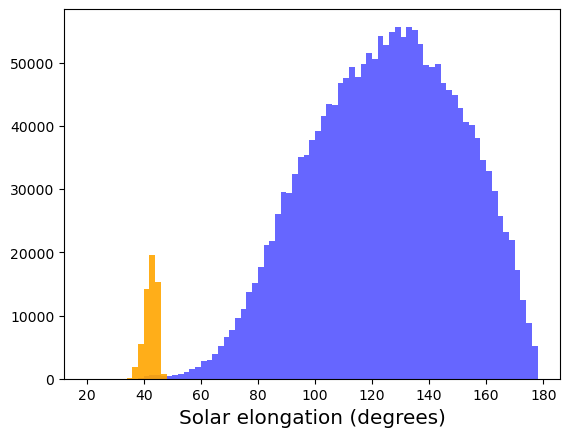

In [44]:
# Check solar elongation
bins = np.arange(20, 180, 2)
_ = plt.hist(visits.query('~scheduler_note.str.contains("near_sun")')['solarElong'], bins=bins, color='blue', alpha=0.6)
_ = plt.hist(visits.query('scheduler_note.str.contains("near_sun")')['solarElong'], bins=bins, color='orange', alpha=0.9, label="Near Sun Twilight Microsurvey")
_ = plt.xlabel("Solar elongation (degrees)", fontsize='x-large')
visits.query("scheduler_note.str.contains('near_sun')")['solarElong'].describe()

In [45]:
query = "select * from observations"
conn = sqlite3.connect('fbs_3.0/baseline_v3.0_10yrs.db')
visits_30 = pd.read_sql(query, conn)

In [46]:
visits_30.observationStartMJD.min()

60218.001805555556

count    45835.000000
mean        54.744497
std          4.124436
min         40.985570
25%         52.027315
50%         55.456454
75%         58.061295
max         61.578717
Name: solarElong, dtype: float64

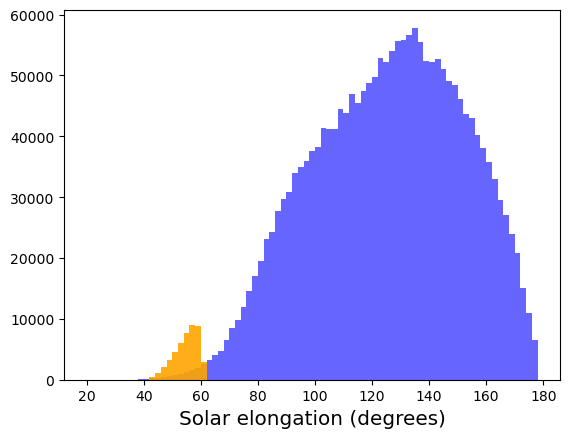

In [47]:
# Check solar elongation
bins = np.arange(20, 180, 2)
_ = plt.hist(visits_30.query('~note.str.contains("neo")')['solarElong'], bins=bins, color='blue', alpha=0.6)
_ = plt.hist(visits_30.query('note.str.contains("neo")')['solarElong'], bins=bins, color='orange', alpha=0.9, label="Near Sun Twilight Microsurvey")
_ = plt.xlabel("Solar elongation (degrees)", fontsize='x-large')
visits_30.query("note.str.contains('neo')")['solarElong'].describe()

Euclid overlap extension illustration (to be paired with v3.0 example below). 

In [48]:
# Highlight the Euclid swoop
targetmap, labels = get_current_footprint(nside=64)
np.unique(labels)
fp = np.zeros(len(labels)) 
fp[np.where(labels == 'euclid_overlap')] = 1
# We could try this for an outline .. 
outline = hp.smoothing(fp, fwhm=0.05, nest=False)
outline = np.where((outline<0.5) & (outline > 0.02), 1, 0)
#hp.mollview(outline)

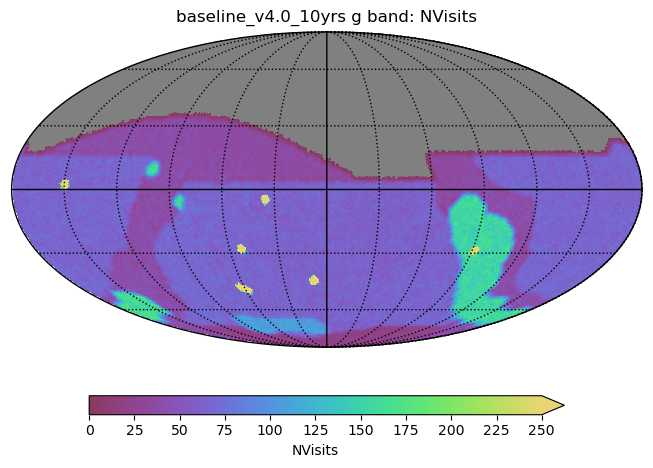

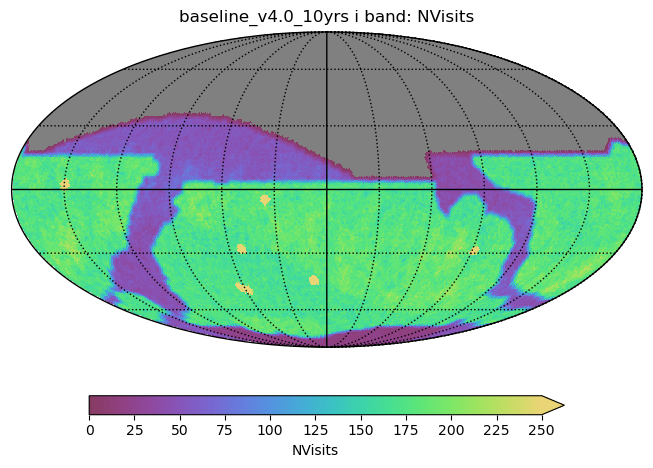

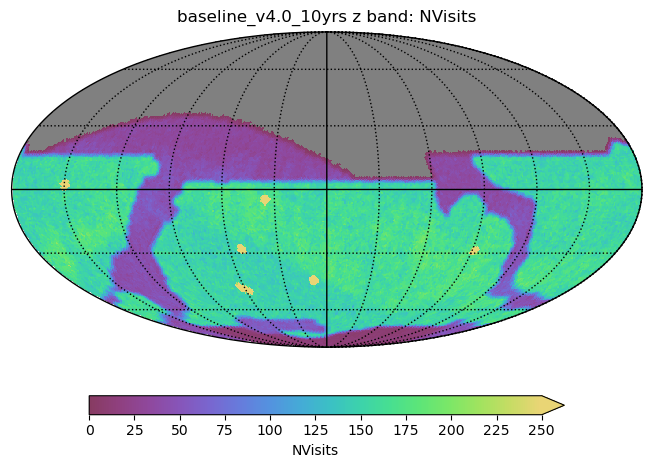

In [49]:
# Filter balance in galactic plane regions

for f in ['g', 'i', 'z']:
    ph.set_metric_bundles([bundles[f]])
    plot_dict = {'color_max': 250, 'extend': 'max'}
    ph.plot(plot_func=maf.plots.HealpixSkyMap(), plot_dicts=plot_dict)


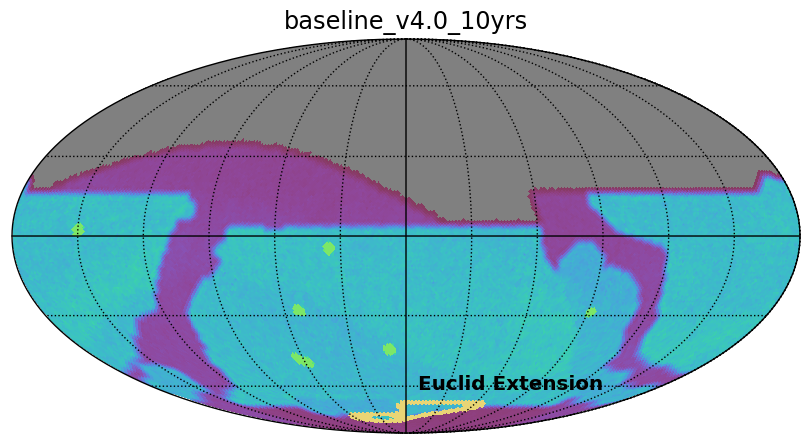

In [50]:
# Euclid extension outline 

bundle_new.metric_values[np.where(bundle_new.metric_values > 1200)] = 1200
bundle_new.metric_values[np.where(outline == 1)] = 10000

ph.set_metric_bundles([bundle_new])
fig = ph.plot(plot_func=maf.plots.HealpixSkyMap(),
            plot_dicts={'color_min': 0, 'color_max':1500, 'figsize': (8, 7),
                   'labelsize': 'x-large', 'fontsize':'x-large', 'xlabel': "Nvisits", 
                    'extend': 'max'})
#plt.figtext(0.51, 0.45, 'Low-dust\n WFD', fontsize='xx-large', fontweight='bold', color='black')
#plt.figtext(0.28, 0.6, 'NES', fontsize='xx-large', fontweight='bold', color='black')
#plt.figtext(0.9, 0.62, "Virgo",  fontsize='large', fontweight='bold', color='black')
#plt.figtext(0.71, 0.35, 'GP\n WFD', fontsize='x-large', fontweight='bold', color='black')
#plt.figtext(0.72, 0.44, 'Roman', fontsize='large', rotation=0, fontweight='bold', color='black')
#plt.figtext(0.18, 0.4, 'Dusty\n Plane', fontsize='x-large', rotation=75, fontweight='bold', color='black')
#plt.figtext(0.56, 0.26, 'SCP', fontsize='xx-large', fontweight='bold', color='black')
#plt.figtext(0.36, 0.38, 'DDFs', fontsize='x-large', fontweight='bold', color='black')
plt.figtext(0.52, 0.31, "Euclid Extension", fontsize='x-large', fontweight='bold', color='black')
plt.title(f'{run_name}', fontsize='xx-large', fontweight='normal')
fig.delaxes(fig.axes[1])
# We have to save the figure separately, because otherwise labels aren't getting saved.
plt.savefig(os.path.join(outdir, f'{run_name.replace(".", "_")}_euclid_overlap.{figformat}' ), 
            facecolor='w', edgecolor='w', bbox_inches='tight',dpi=270, format=figformat)

In [51]:
# Some runs needed a comparison footprint 
opsdb = 'fbs_3.0/baseline_v3.0_10yrs.db'
run_name = os.path.split(opsdb)[-1].replace('.db', '')


filterlist, colors, orders, sqls, infos = maf.filter_list(all=True)
bundles = {}
metric = maf.CountMetric('observationStartMJD', metric_name='NVisits')
slicer = maf.HealpixSlicer(nside=64)
for f in filterlist:
    if f == "all":
        colormax = 1000
    elif f in ('u', 'g'):
        colormax = 100
    else:
        colormax = 250
    plot_dict = {'color_min': 0, 'color_max': colormax, 'extend': 'max', 'color': colors[f]}
    plot_funcs = [maf.HealpixSkyMap(),]
    bundles[f] = maf.MetricBundle(metric, slicer, sqls[f], run_name=run_name, 
                              plot_dict=plot_dict, plot_funcs=plot_funcs, info_label=infos[f])

try_read = try_read_default
if try_read:
    for b in bundles:
        bundles[b].read(os.path.join(outdir, bundles[b].file_root + ".npz"))
else:
    g = maf.MetricBundleGroup(bundles, opsdb, out_dir=outdir, verbose=True)
    g.run_all()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [52]:
bundle30 = copy.deepcopy(bundles['all'])

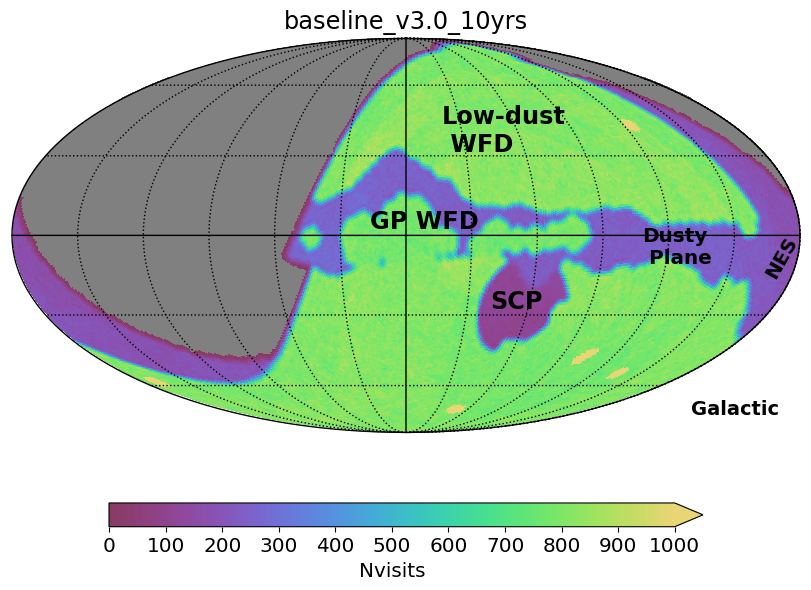

In [53]:
ph.set_metric_bundles([bundles['all']])
ph.plot(plot_func=maf.plots.HealpixSkyMap(),
        plot_dicts={'color_min': 0, 'color_max':1000, 'figsize': (8, 7),
                   'labelsize': 'x-large', 'fontsize':'x-large', 'xlabel': "Nvisits", 
                    'extend': 'max', 'coord': ["C", "G"]})
plt.figtext(0.55, 0.65, 'Low-dust\n WFD', fontsize='xx-large', fontweight='bold', color='black')
plt.figtext(0.95, 0.47, 'NES', fontsize='x-large', rotation=60, fontweight='bold', color='black')
#plt.figtext(0.9, 0.62, "Virgo",  fontsize='large', fontweight='bold', color='black')
plt.figtext(0.46, 0.54, 'GP WFD', fontsize='xx-large', fontweight='bold', color='black')
#plt.figtext(0.42, 0.50, 'Roman', fontsize='large', rotation=0, fontweight='bold', color='black')
plt.figtext(0.80, 0.49, 'Dusty\n Plane', fontsize='x-large', rotation=0, fontweight='bold', color='black')
plt.figtext(0.61, 0.425, 'SCP', fontsize='xx-large', fontweight='bold', color='black')
#plt.figtext(0.36, 0.38, 'DDFs', fontsize='x-large', fontweight='bold', color='black')
plt.title(f'{run_name}', fontsize='xx-large', fontweight='normal')
# We have to save the figure separately, because otherwise labels aren't getting saved.
plt.savefig(os.path.join(outdir, f'{run_name.replace(".", "_")}_nvisits_galactic.{figformat}' ), 
            facecolor='w', edgecolor='w', bbox_inches='tight',dpi=270, format=figformat)

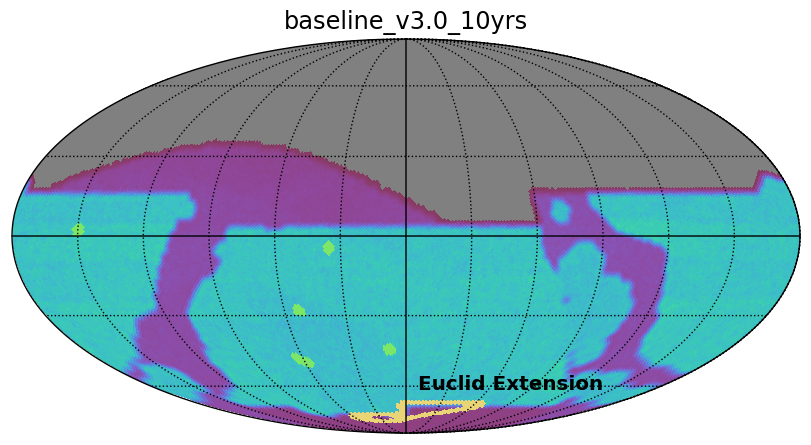

In [54]:
bundle30.metric_values[np.where(bundle30.metric_values.filled(0) > 1200 )] = 1200
bundle30.metric_values[np.where(outline == 1)] = 10000

ph.set_metric_bundles([bundle30])
fig = ph.plot(plot_func=maf.plots.HealpixSkyMap(),
            plot_dicts={'color_min': 0, 'color_max':1500, 'figsize': (8, 7),
                   'labelsize': 'x-large', 'fontsize':'x-large', 'xlabel': "Nvisits", 
                    'extend': 'max'})
#plt.figtext(0.51, 0.45, 'Low-dust\n WFD', fontsize='xx-large', fontweight='bold', color='black')
#plt.figtext(0.28, 0.6, 'NES', fontsize='xx-large', fontweight='bold', color='black')
#plt.figtext(0.9, 0.62, "Virgo",  fontsize='large', fontweight='bold', color='black')
#plt.figtext(0.71, 0.35, 'GP\n WFD', fontsize='x-large', fontweight='bold', color='black')
#plt.figtext(0.72, 0.44, 'Roman', fontsize='large', rotation=0, fontweight='bold', color='black')
#plt.figtext(0.18, 0.4, 'Dusty\n Plane', fontsize='x-large', rotation=75, fontweight='bold', color='black')
#plt.figtext(0.56, 0.26, 'SCP', fontsize='xx-large', fontweight='bold', color='black')
#plt.figtext(0.36, 0.38, 'DDFs', fontsize='x-large', fontweight='bold', color='black')
plt.figtext(0.52, 0.31, "Euclid Extension", fontsize='x-large', fontweight='bold', color='black')
plt.title(f'{run_name}', fontsize='xx-large', fontweight='normal')
fig.delaxes(fig.axes[1])
# We have to save the figure separately, because otherwise labels aren't getting saved.
plt.savefig(os.path.join(outdir, f'{run_name.replace(".", "_")}_euclid_overlap.{figformat}' ), 
            facecolor='w', edgecolor='w', bbox_inches='tight',dpi=270, format=figformat)

In [55]:
# ToO impact in v3.5 and v3.6

In [56]:
rr = ['too_v3.5_10yrs', 'baseline_v3.5_10yrs', 'baseline_v3.6_10yrs', 'no_too_v3.6_10yrs']
ref = 'baseline_v3.6_10yrs'
v35 = ['too_v3.5_10yrs', 'baseline_v3.5_10yrs']
ref35 = 'too_v3.5_10yrs'
v36 = ['baseline_v3.6_10yrs', 'no_too_v3.6_10yrs']
ref36 = 'baseline_v3.6_10yrs'

In [57]:
msub = metrics.loc['SCOC']
s1 = maf.normalize_metric_summaries(baseline_run=ref35, summary=summaries.loc[v35, msub['metric']], metric_subsets=msub)
s2 = maf.normalize_metric_summaries(baseline_run=ref36, summary=summaries.loc[v36, msub['metric']], metric_subsets=msub)
ss = pd.concat([s1, s2])

(<Figure size 600x600 with 2 Axes>, <Axes: >)

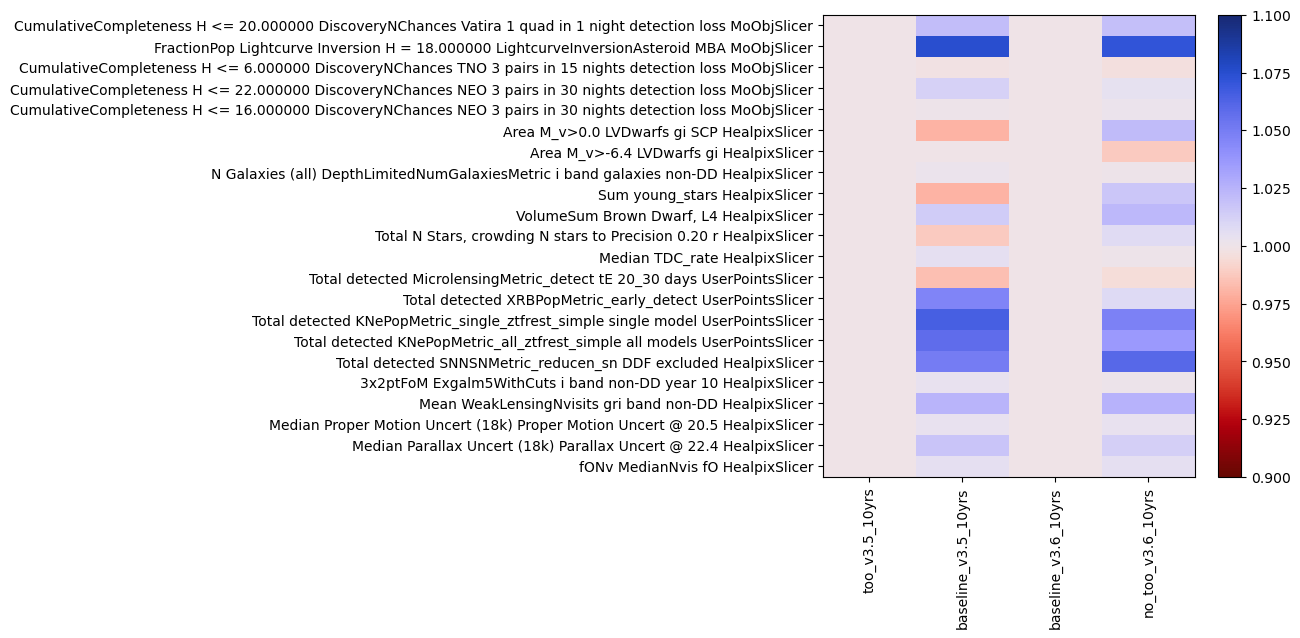

In [58]:
maf.plot_run_metric_mesh(ss, color_range=0.2)# , vertical_quantity='value', horizontal_quantity='run', linestyles='-')

(<Figure size 600x600 with 2 Axes>, <Axes: >)

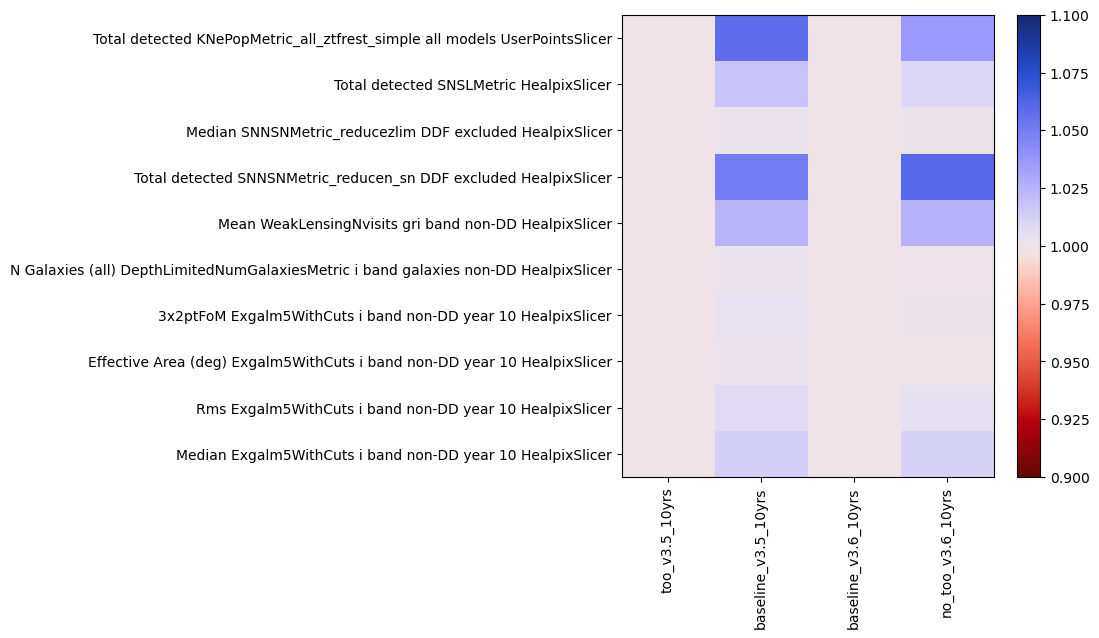

In [59]:
msub = metrics.loc['DESC WFD']
s1 = maf.normalize_metric_summaries(baseline_run=ref35, summary=summaries.loc[v35, msub['metric']], metric_subsets=msub)
s2 = maf.normalize_metric_summaries(baseline_run=ref36, summary=summaries.loc[v36, msub['metric']], metric_subsets=msub)
ss = pd.concat([s1, s2])

maf.plot_run_metric_mesh(ss, color_range=0.2)

In [60]:
conn = sqlite3.connect('fbs_4.0/baseline_v4.0_10yrs.db')
visits = pd.read_sql('select * from observations', conn)

In [61]:
len(visits.query('scheduler_note.str.contains("long")')) / len(visits)

0.04157097350480763

In [62]:
len(visits.query('target_name.str.contains("DD")')) #/ len(visits)

138038

In [63]:
len(visits.query('target_name.str.contains("COSMOS")')) / len(visits.query('target_name.str.contains("DD")')) 

0.31581158811341803

In [64]:
vv = visits.query('~scheduler_note.str.contains("DD")')#.query('fieldDec < -70')
vv.groupby(['night', 'fieldRA', 'fieldDec']).count()['observationStartMJD'].rename("count").describe()

count    961948.000000
mean          1.973871
std           0.590027
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max          13.000000
Name: count, dtype: float64

In [65]:
too = visits.query('scheduler_note.str.contains("ToO")')
too.visitExposureTime.sum() / visits.visitExposureTime.sum(), len(too)/len(visits)

(0.039684872471441424, 0.010934772990149286)

### Variability due to start date 

In [66]:
# should add more simulations at v4.1 with this .. 

summaries = maf.get_metric_summaries(summary_source='fbs_3.4/summary_good.h5')

In [67]:
start_times = [r for r in summaries.index if "start_date" in r]
offsets = [int(s.split("do")[-1].split('v3.4')[0]) for s in start_times]
offsets = np.sort(np.array(offsets))
start_times = [f'start_date_do{o}v3.4_10yrs' for o in offsets]
sdict = dict([(s, f'offset {o}') for s, o in zip(start_times, offsets)])

weather_v4 = [r for r in summaries.index if "weather" in r]
wdict = dict([(w, w.split('clouds')[-1].split('v3.4')[0]) for w in weather_v4])

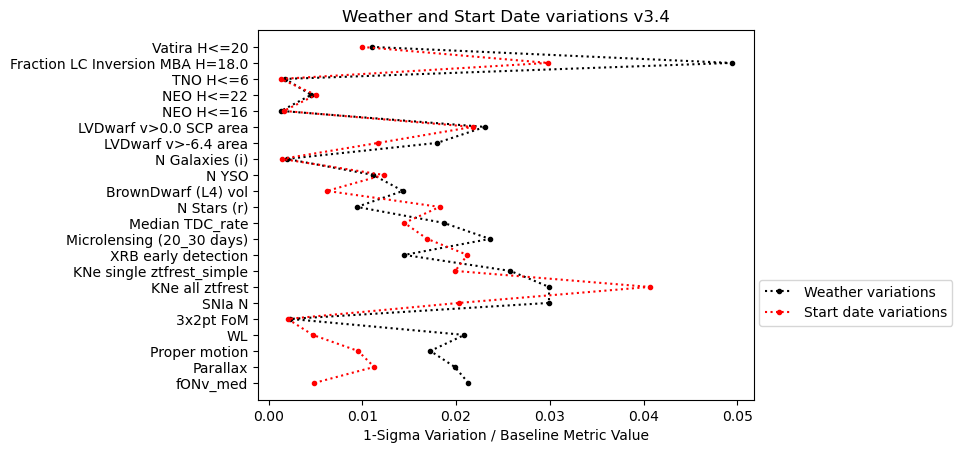

In [68]:
msub = metrics.loc['SCOC']
weather_dev = np.std(summaries.loc[weather_v4, msub['metric']], axis=0) / summaries.loc['start_date_do0v3.4_10yrs', msub['metric']]
start_dev = np.std(summaries.loc[start_times, msub['metric']], axis=0) / summaries.loc['start_date_do0v3.4_10yrs', msub['metric']]

plt.plot(weather_dev.values, msub['short_name'], 'k.', linestyle=':', label='Weather variations')
plt.plot(start_dev.values, msub['short_name'], 'r.', linestyle=':', label='Start date variations')
plt.legend(loc=(1.01, 0.2))
_ = plt.title("Weather and Start Date variations v3.4")
_ =plt.xlabel("1-Sigma Variation / Baseline Metric Value")
plt.savefig(os.path.join(outdir, 'uncertainties_v3.4.png'), bbox_inches='tight')

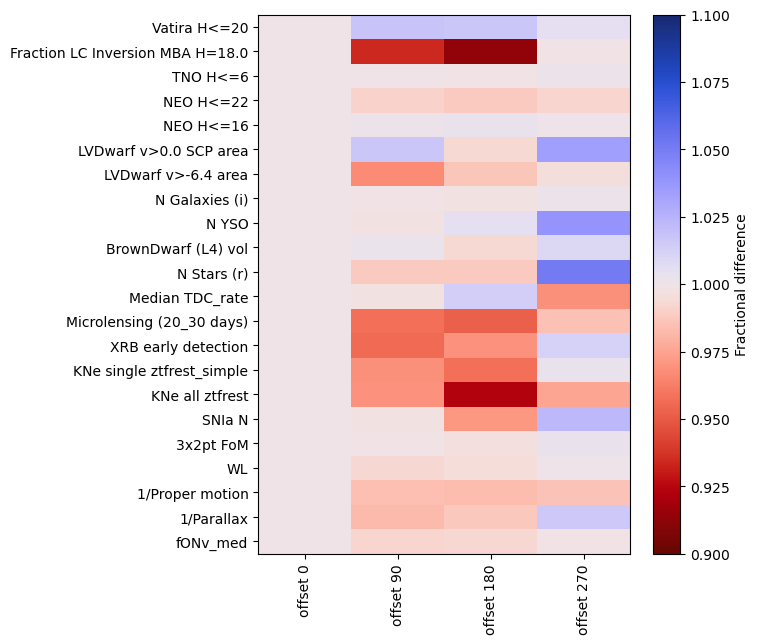

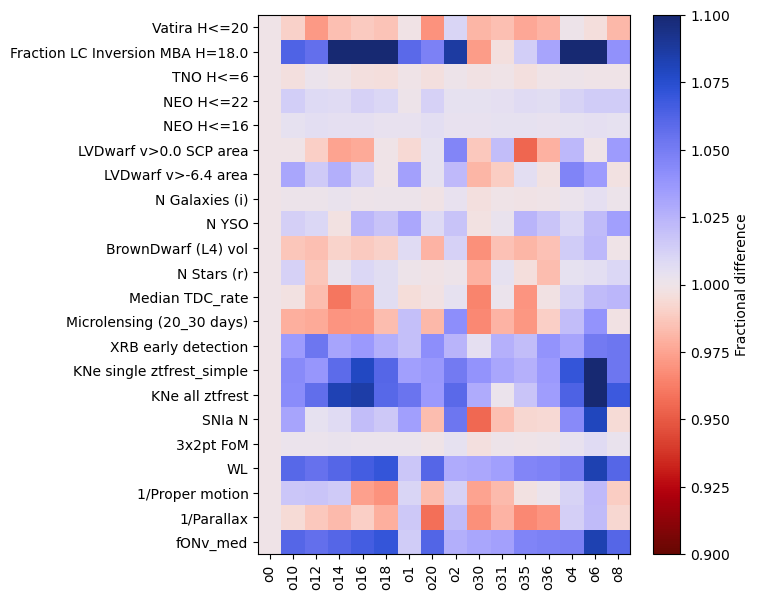

In [69]:
msub = metrics.loc['SCOC']

fig, ax = maf.plot_run_metric_mesh(summaries.loc[start_times[4:8], msub['metric']],
                                   baseline_run='start_date_do0v3.4_10yrs',
                                 metric_subset=msub,
                                metric_label_map=msub['short_name'],
                                run_label_map=sdict,
                                   color_range=0.2,
                      )
fig.set_figheight(7)
plt.savefig(os.path.join(outdir, 'start_date_scoc_heatmap.png'),  bbox_inches='tight')

msub = metrics.loc['SCOC']

fig, ax = maf.plot_run_metric_mesh(summaries.loc[weather_v4, msub['metric']], 
                     baseline_run='weather_cloudso0v3.4_10yrs',
                     metric_subset=msub,
                        metric_label_map=msub['short_name'],
                        run_label_map=wdict,
                                   color_range=0.2,
                      )
fig.set_figheight(7)
plt.savefig(os.path.join(outdir, 'weather_scoc_heatmap.png'),  bbox_inches='tight')